# Molecular dynamics analysis of HIV-1 protease

This Jupyter notebook presents a molecular dynamics analysis of the Human Immunodeficiency Virus type I (HIV-1) protease. We simulated HIV-1 protease (PDB ID: 1HVR) without its ligand for 201 ns. Then, a total of 201 frames were extracted at regular intervals of 1 ns from the molecular dynamics’ trajectory.

Here, we describe the conformational changes of a cavity that defines the active site of the HIV-1 protease, which is an effective therapeutic target. The HIV-1 protease catalytic cycle involves movements of β -hairpins, called 'flaps', which control the accessibility of substrates to the active site of the homodimer. Further, we performed a occurence of cavity points, that were detected in at least two frames, and we plotted all properties (volume, area, depth and hydropathy) throughout the simulation.

In [1]:
# Import required modules
import os
import toml
import numpy
import nglview
import pickle
import IPython
import pyKVFinder
import KVFinderMD
import SERD
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymol
from pymol import cmd, stored
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

## HIV-1 protease trajectory

In [2]:
# Load trajectory
traj = mda.Universe('data/HIV.pdb')
view = nglview.show_mdanalysis(traj)

# Display on NGL viewer
view.display()

NGLWidget(max_frame=200)

## Cavity detection and characterization workflow


In [3]:
if os.path.exists("results/HIV/md.pkl"):
    with open("results/HIV/md.pkl", "rb") as f:
        md = pickle.load(f)
    md.occurrence._gap = 1
else: 
    # Create KVFinderMD object
    md = KVFinderMD.KVFinderMD()

    # Load HIV-1 protease trajectory
    md.read_trajectory("data/HIV.pdb")

    # Custom detection parameters
    probe_out = 12.0
    volume_cutoff = 50.0

    # Perform detection and characterization
    md.detect(
        # Analysis modes
        analyze_constitutional=True, 
        export_occurrence=True,
        analyze_spatial=True, 
        analyze_depth=True, 
        analyze_hydropathy=True,
        # Custom parameters
        probe_out=probe_out, 
        volume_cutoff=volume_cutoff,
        # Miscellaneous
        basedir='results/HIV',
        verbose=True
    )
    
    # Write characterization to file
    md.write('results/HIV/results.toml')
    
    # Save md with pickle
    with open("results/HIV/md.pkl", "wb") as f:
        pickle.dump(md, f)

[Frame:   0]  Elapsed time: 00s  Estimated time: 17s            

/home/ABTLUS/joao.guerra/anaconda3/envs/jupyter/lib/python3.9/site-packages/MDAnalysis/core/universe.py:641: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,



[Frame:   1]  Elapsed time: 02s  Estimated time: 04m14s            
[Frame:   2]  Elapsed time: 04s  Estimated time: 05m15s            
[Frame:   3]  Elapsed time: 07s  Estimated time: 05m47s            
[Frame:   4]  Elapsed time: 09s  Estimated time: 06m03s            
[Frame:   5]  Elapsed time: 11s  Estimated time: 06m15s            
[Frame:   6]  Elapsed time: 13s  Estimated time: 06m25s            
[Frame:   7]  Elapsed time: 16s  Estimated time: 06m29s            
[Frame:   8]  Elapsed time: 18s  Estimated time: 06m32s            
[Frame:   9]  Elapsed time: 20s  Estimated time: 06m36s            
[Frame:  10]  Elapsed time: 23s  Estimated time: 06m39s            
[Frame:  11]  Elapsed time: 25s  Estimated time: 06m41s            
[Frame:  12]  Elapsed time: 29s  Estimated time: 07m01s            
[Frame:  13]  Elapsed time: 32s  Estimated time: 07m20s            
[Frame:  14]  Elapsed time: 37s  Estimated time: 07m42s            
[Frame:  15]  Elapsed time: 40s  Estimated time

[Frame: 117]  Elapsed time: 04m41s  Estimated time: 03m17s            
[Frame: 118]  Elapsed time: 04m43s  Estimated time: 03m15s            
[Frame: 119]  Elapsed time: 04m46s  Estimated time: 03m13s            
[Frame: 120]  Elapsed time: 04m48s  Estimated time: 03m10s            
[Frame: 121]  Elapsed time: 04m51s  Estimated time: 03m08s            
[Frame: 122]  Elapsed time: 04m53s  Estimated time: 03m06s            
[Frame: 123]  Elapsed time: 04m55s  Estimated time: 03m03s            
[Frame: 124]  Elapsed time: 04m58s  Estimated time: 03m01s            
[Frame: 125]  Elapsed time: 05m00s  Estimated time: 02m59s            
[Frame: 126]  Elapsed time: 05m03s  Estimated time: 02m56s            
[Frame: 127]  Elapsed time: 05m05s  Estimated time: 02m54s            
[Frame: 128]  Elapsed time: 05m08s  Estimated time: 02m51s            
[Frame: 129]  Elapsed time: 05m10s  Estimated time: 02m49s            
[Frame: 130]  Elapsed time: 05m12s  Estimated time: 02m47s            
[Frame

### Visualize cavity analysis

- Spatial conservation (%)
- Spatial characterization (shape, volume, area)
- Depth characeterization
- Hydropathy characterization

In [4]:
# NGLView: Visualize occurrence of cavity points (rainbow scale)

# Create NGL Viewer widget
view = nglview.NGLWidget()

# Display trajectory
pdb = view.add_component('data/HIV.pdb')
pdb.clear()
pdb.add_cartoon(color='gray')

# Display occurrence of cavity points
cavs = view.add_component('results/HIV/occurrence.KVFinder.output.pdb')
cavs.clear()
cavs.add_point(colorScheme='bfactor',
              colorScale='rainbow',
              colorReverse=True
             )

# Display on NGL viewer
view

NGLWidget()

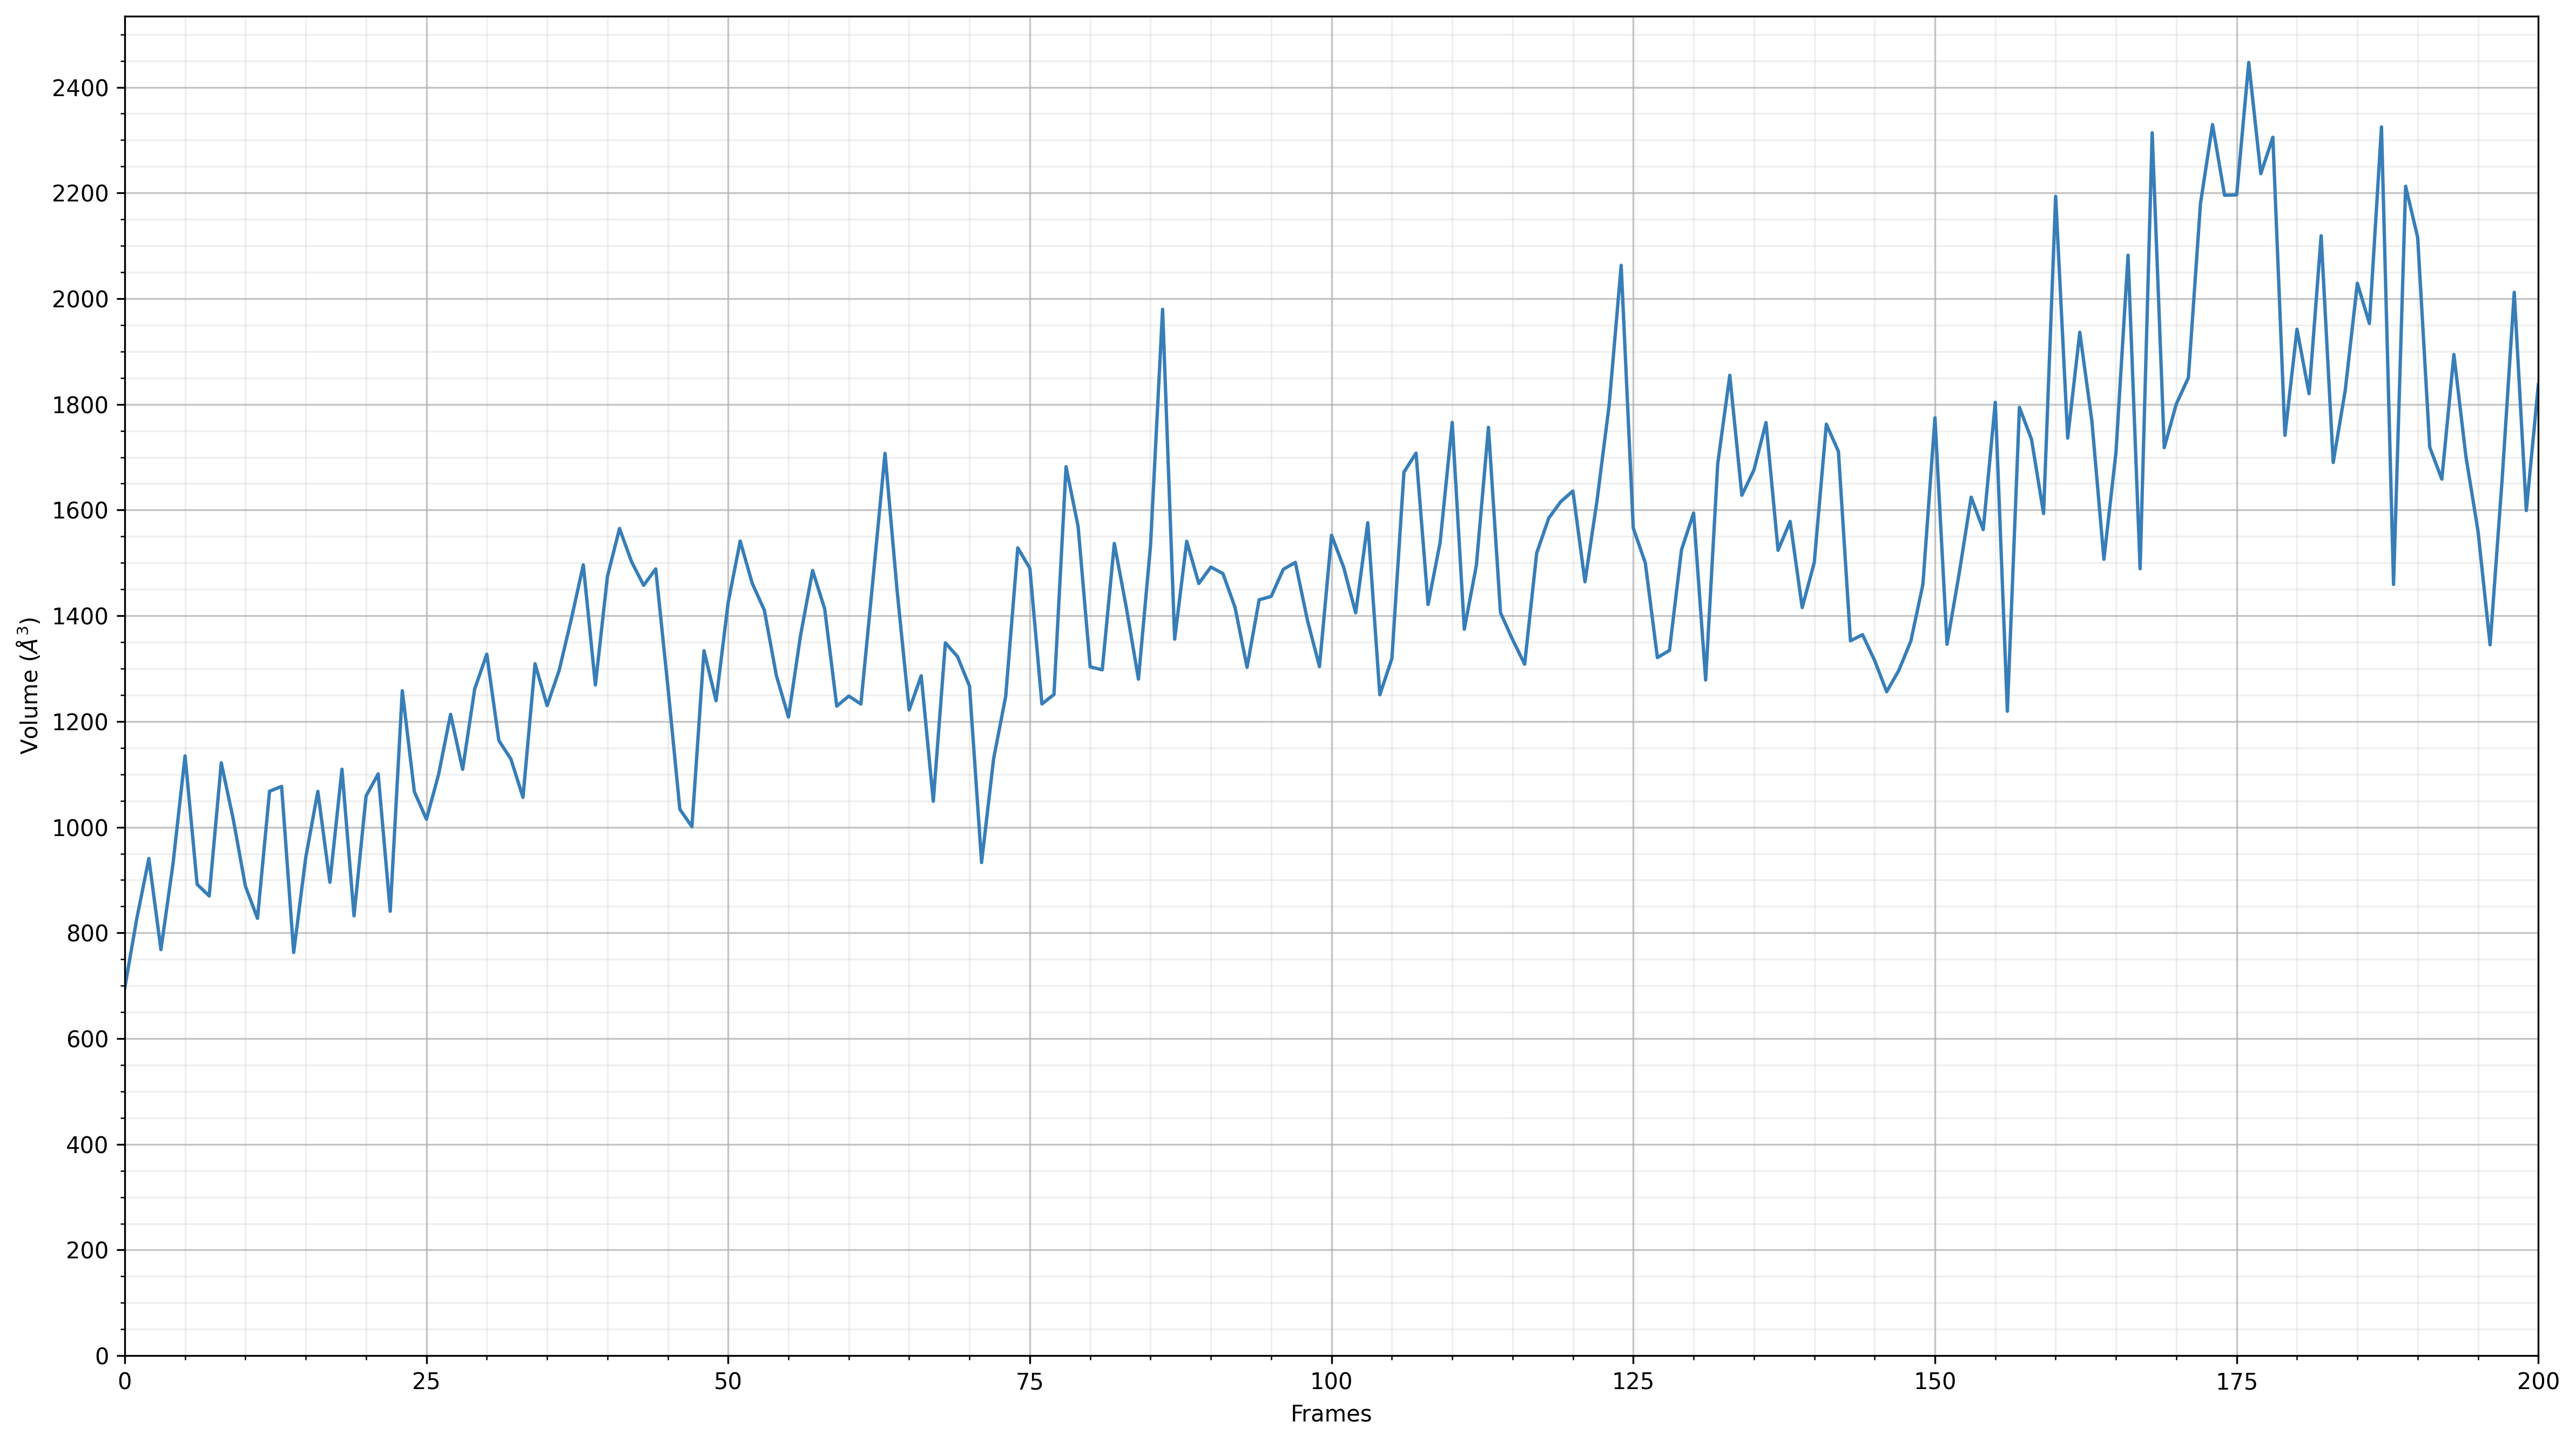

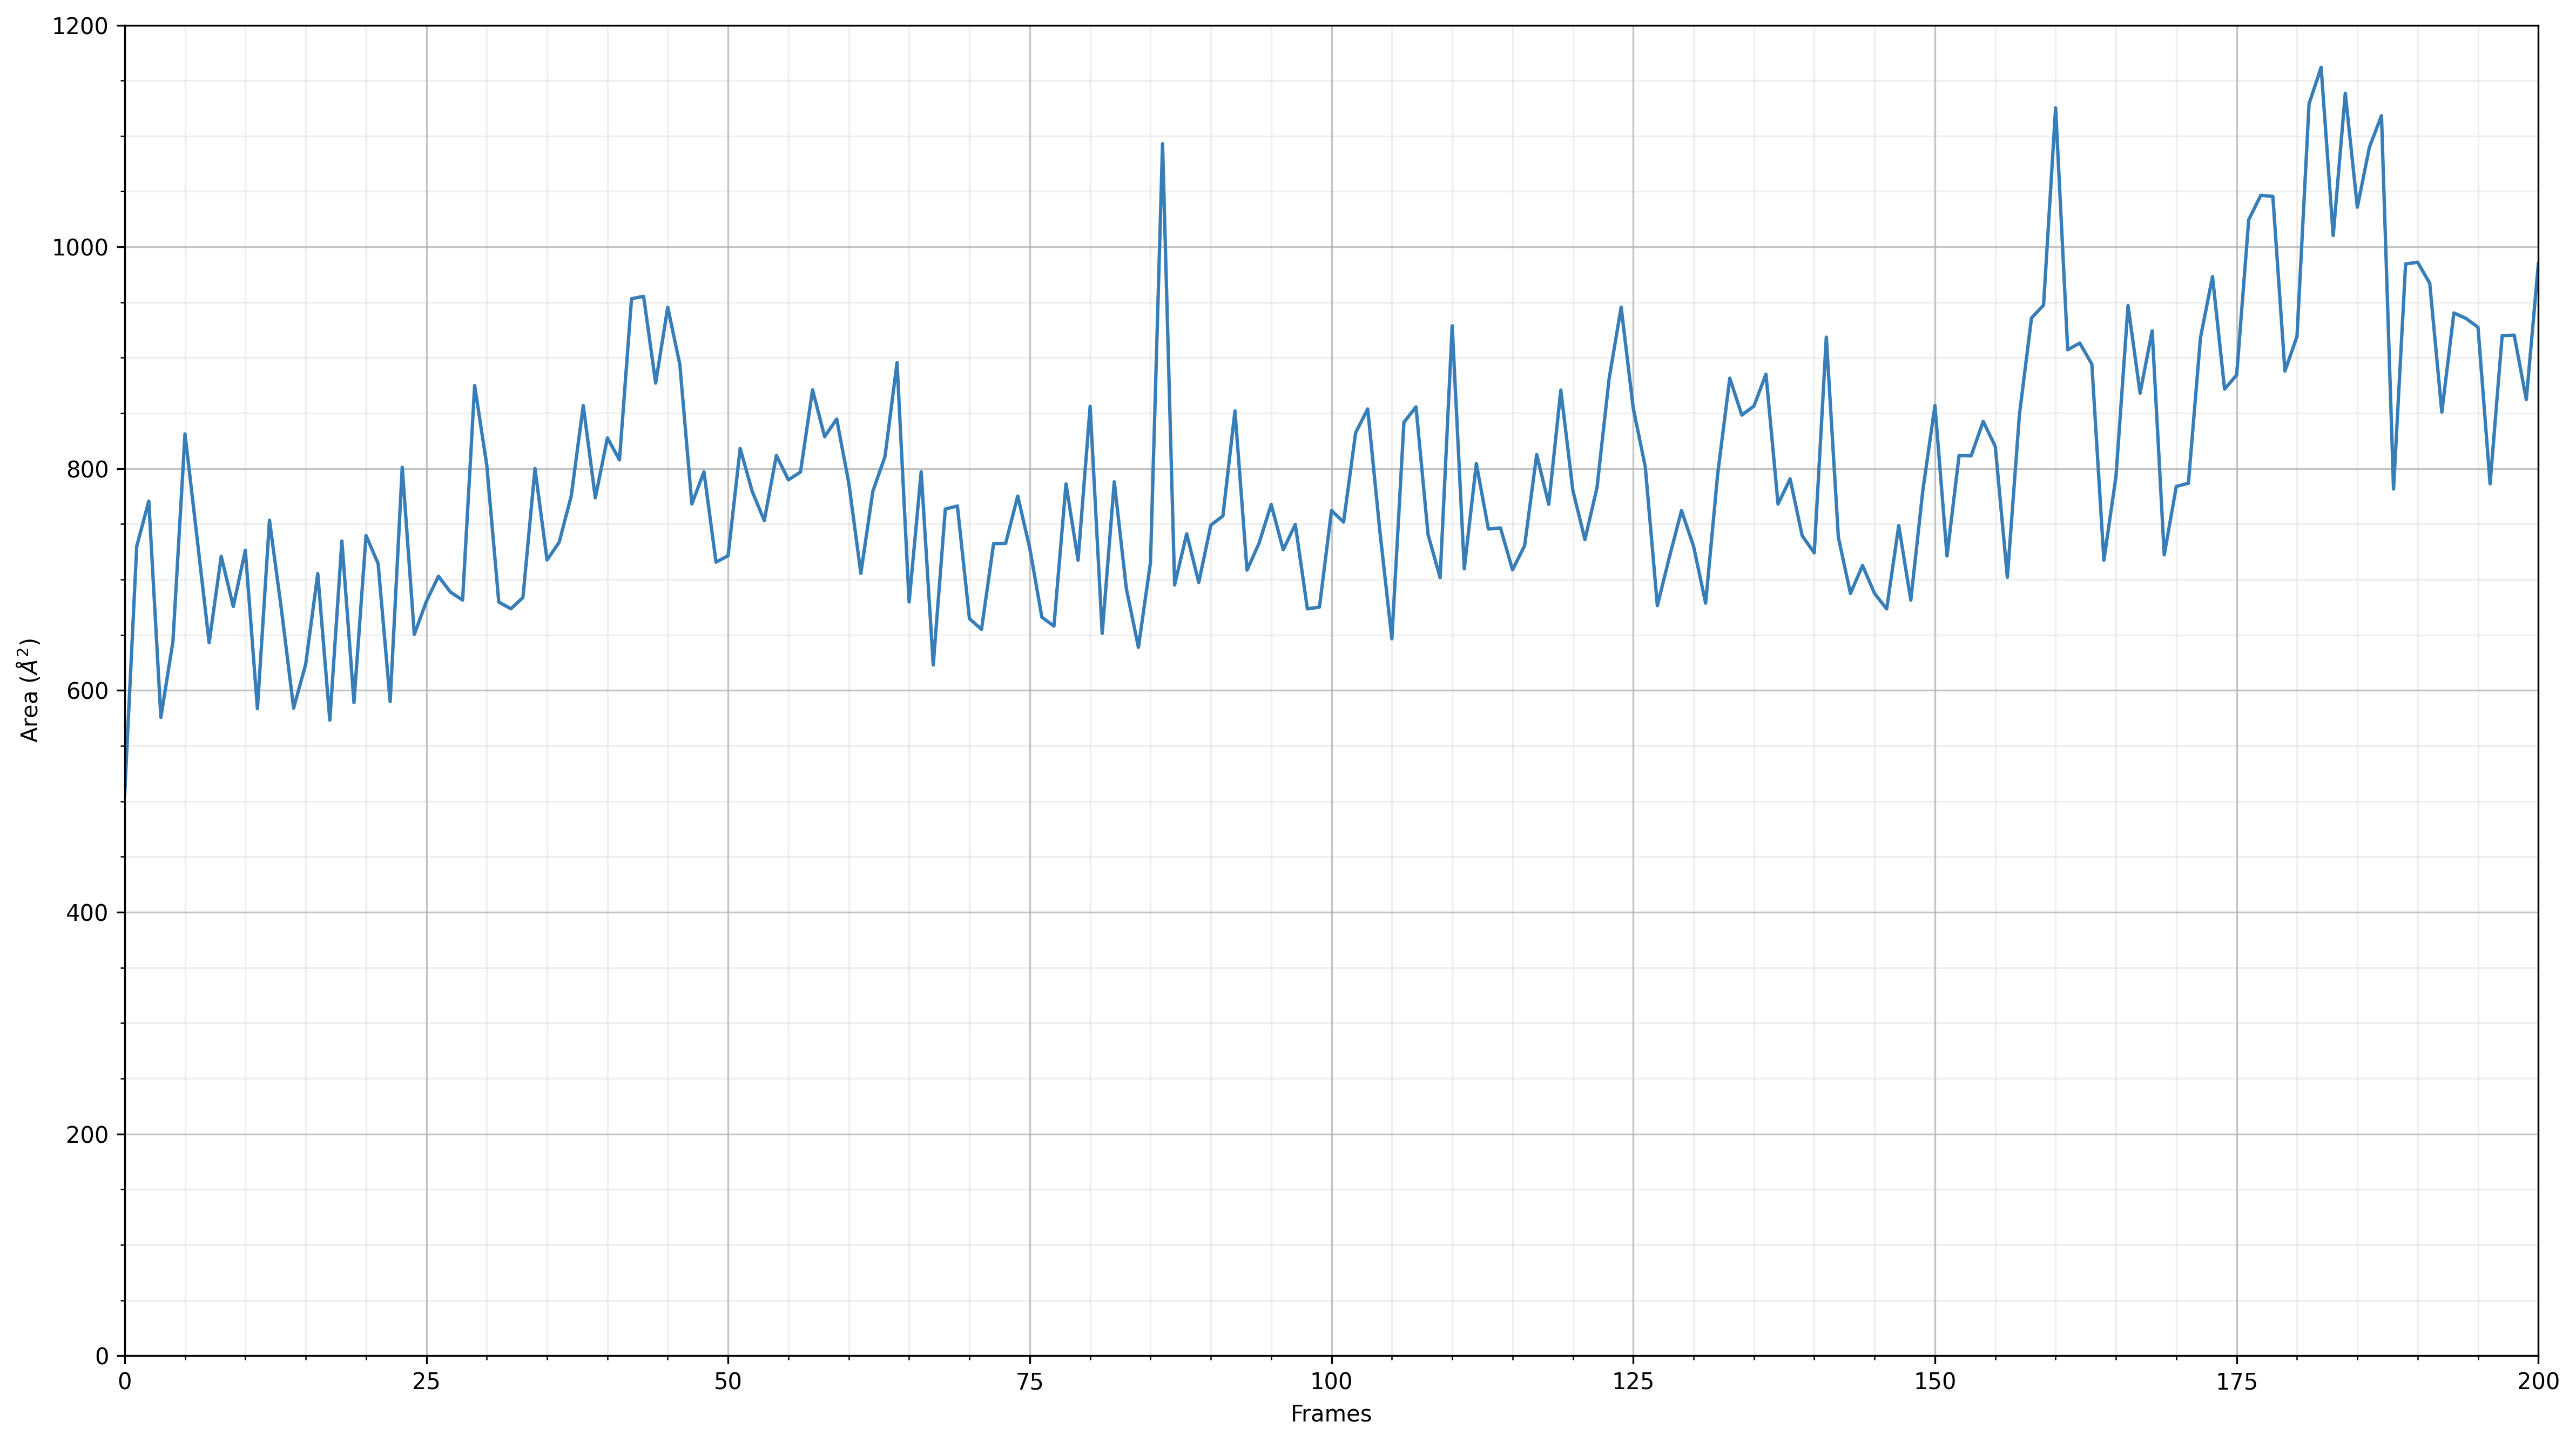

In [5]:
# Spatial characterization
md.timeplot(['volume', 'area'], format=None)

In [6]:
# PyMOL v2.5.0: Visualize spatial, depth and hydropathy
os.makedirs("pymol/HIV/", exist_ok=True)

with open("pymol/HIV/visualize-characterization.py", "w") as f:
    f.write("""import pymol
from pymol import cmd, stored

# Launch pymol
pymol.finish_launching(['pymol', '-q'])

# Load trajectory
cmd.load("data/HIV.pdb")

# Spatial conservation (%)
cmd.load("results/HIV/occurrence.KVFinder.output.pdb")
stored.b = []
cmd.iterate("(obj occurrence.KVFinder.output)", "stored.b.append(b)")
cmd.spectrum("b", "rainbow", "occurrence.KVFinder.output", [0.0, max(stored.b)])
cmd.ramp_new("conservation", "occurrence.KVFinder.output", [0.0, max(stored.b)], ["blue", "white", "red"])
cmd.alter("obj occurrence.KVFinder.output", "vdw=0.3")
cmd.hide("everything", "occurrence.KVFinder.output")
cmd.show("spheres", "occurrence.KVFinder.output")

# Depth characterization
cmd.load("results/HIV/cavities.KVFinder.output.pdb")
stored.b = []
cmd.iterate("(obj cavities.KVFinder.output)", "stored.b.append(b)")
cmd.spectrum("b", "blue_white_red", "cavities.KVFinder.output", [min(stored.b), max(stored.b)])
cmd.ramp_new("depth", "cavities.KVFinder.output", [min(stored.b), max(stored.b)], ["blue", "white", "red"])
cmd.alter("obj cavities.KVFinder.output", "vdw=0.3")
cmd.hide("everything", "cavities.KVFinder.output")
cmd.show("spheres", "cavities.KVFinder.output")

# Hydropathy characterization
cmd.load("results/HIV/hydropathy.KVFinder.output.pdb")
stored.b = []
cmd.iterate("(obj hydropathy.KVFinder.output)", "stored.b.append(b)")
cmd.spectrum("b", "yellow_white_blue", "hydropathy.KVFinder.output", [min(stored.b), max(stored.b)])
cmd.ramp_new("EisenbergWeiss", "hydropathy.KVFinder.output", [min(stored.b), max(stored.b)], ["yellow", "white", "blue"])
cmd.alter("obj hydropathy.KVFinder.output", "vdw=0.3")
cmd.hide("everything", "hydropathy.KVFinder.output")
cmd.show("spheres", "hydropathy.KVFinder.output")

# Apply changes
cmd.rebuild()
cmd.orient()
cmd.save("results/HIV/characterization.pse")
"""
    )

# Run script in pymol    
os.system(f"pymol pymol/HIV/visualize-characterization.py")

 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected OpenGL version 4.6. Shaders available.
 Detected GLSL version 4.60.
 OpenGL graphics engine:
  GL_VENDOR:   NVIDIA Corporation
  GL_RENDERER: NVIDIA GeForce RTX 3060/PCIe/SSE2
  GL_VERSION:  4.6.0 NVIDIA 515.65.01
 Detected 12 CPU cores.  Enabled

0

In [7]:
# PyMOL v2.5.0: Visualize constitutional characterization
os.makedirs("pymol/HIV/", exist_ok=True)

# Set frame number and cavity name
# n_frame, cavity_name = 0, "KAC"
n_frame, cavity_name = 176, "KAB"

# Get interface residues from frame
frame = md.frame(n_frame)
print(frame._residues)
residues = [f"(resi {i[0]} and chain {i[1]})" for i in md.frame(n_frame)._residues[cavity_name]]

with open("pymol/HIV/visualize-residues.py", "w") as f:
    f.write(f"""import pymol
from pymol import cmd

# Launch pymol
pymol.finish_launching(['pymol', '-q'])

# Load trajectory
cmd.load("data/HIV.pdb")

# Select interface residues
cmd.set("state", {n_frame+1})
cmd.select("residues", "obj HIV and ({' or '.join(residues)})")
cmd.show("sticks", "residues")
cmd.color("red", "residues")
cmd.disable("residues")

cmd.orient()
cmd.save("results/HIV/residues.pse")
"""
    )

# Run script in pymol    
os.system(f"pymol pymol/HIV/visualize-residues.py")

{'KAA': [['39', 'B', 'PRO'], ['40', 'B', 'GLY'], ['41', 'B', 'ARG'], ['42', 'B', 'TRP'], ['43', 'B', 'LYS'], ['58', 'B', 'GLN'], ['59', 'B', 'TYR'], ['60', 'B', 'ASP'], ['61', 'B', 'GLN'], ['62', 'B', 'ILE']], 'KAB': [['8', 'A', 'ARG'], ['23', 'A', 'LEU'], ['25', 'A', 'ASP'], ['26', 'A', 'THR'], ['27', 'A', 'GLY'], ['28', 'A', 'ALA'], ['29', 'A', 'ASP'], ['30', 'A', 'ASP'], ['32', 'A', 'VAL'], ['47', 'A', 'ILE'], ['48', 'A', 'GLY'], ['49', 'A', 'GLY'], ['50', 'A', 'ILE'], ['54', 'A', 'ILE'], ['55', 'A', 'LYS'], ['56', 'A', 'VAL'], ['57', 'A', 'ARG'], ['58', 'A', 'GLN'], ['74', 'A', 'THR'], ['76', 'A', 'LEU'], ['77', 'A', 'VAL'], ['78', 'A', 'GLY'], ['79', 'A', 'PRO'], ['80', 'A', 'THR'], ['81', 'A', 'PRO'], ['82', 'A', 'VAL'], ['84', 'A', 'ILE'], ['87', 'A', 'ARG'], ['88', 'A', 'ASN'], ['90', 'A', 'LEU'], ['5', 'B', 'LEU'], ['7', 'B', 'GLN'], ['8', 'B', 'ARG'], ['9', 'B', 'PRO'], ['23', 'B', 'LEU'], ['25', 'B', 'ASP'], ['27', 'B', 'GLY'], ['28', 'B', 'ALA'], ['29', 'B', 'ASP'], ['30', 

0

## Cavity alignment analysis

We explored three formulations for structural alignment of cavities:
- 3D grid alignment;
- (2D) Contact matrix alignment;
- (2D) Distance matrix alignment - Inspired on DALI structural alignment.


In [8]:
# Create directories
os.makedirs("results/HIV/grid", exist_ok=True)
os.makedirs("results/HIV/contact", exist_ok=True)
os.makedirs("results/HIV/distance", exist_ok=True)

### 3D grid alignment: clustering 3D grid of each cavity detected throughout the molecular dynamics simulation

Here, we separate each cavity in a different boolean grid (1: cavity; 0: everything else).

In [9]:
# Separate each cavity in a different boolean grid
cavities = list()

for n in range(md.n_frames):
    f = md.frame(n)
    for ncav in range(f.n_cavities):
        cav = (f.cavities == ncav+2)
        cavities.append(cav)

cavities = numpy.asarray(cavities)

# Show grids
print(cavities.shape)

(672, 160, 126, 105)


In [10]:
# Prepare data
# NOTE: Memory consuming step
cavities = cavities.astype(bool).reshape(672, -1)

# Show data
print(cavities.shape)

(672, 2116800)


(672, 672)


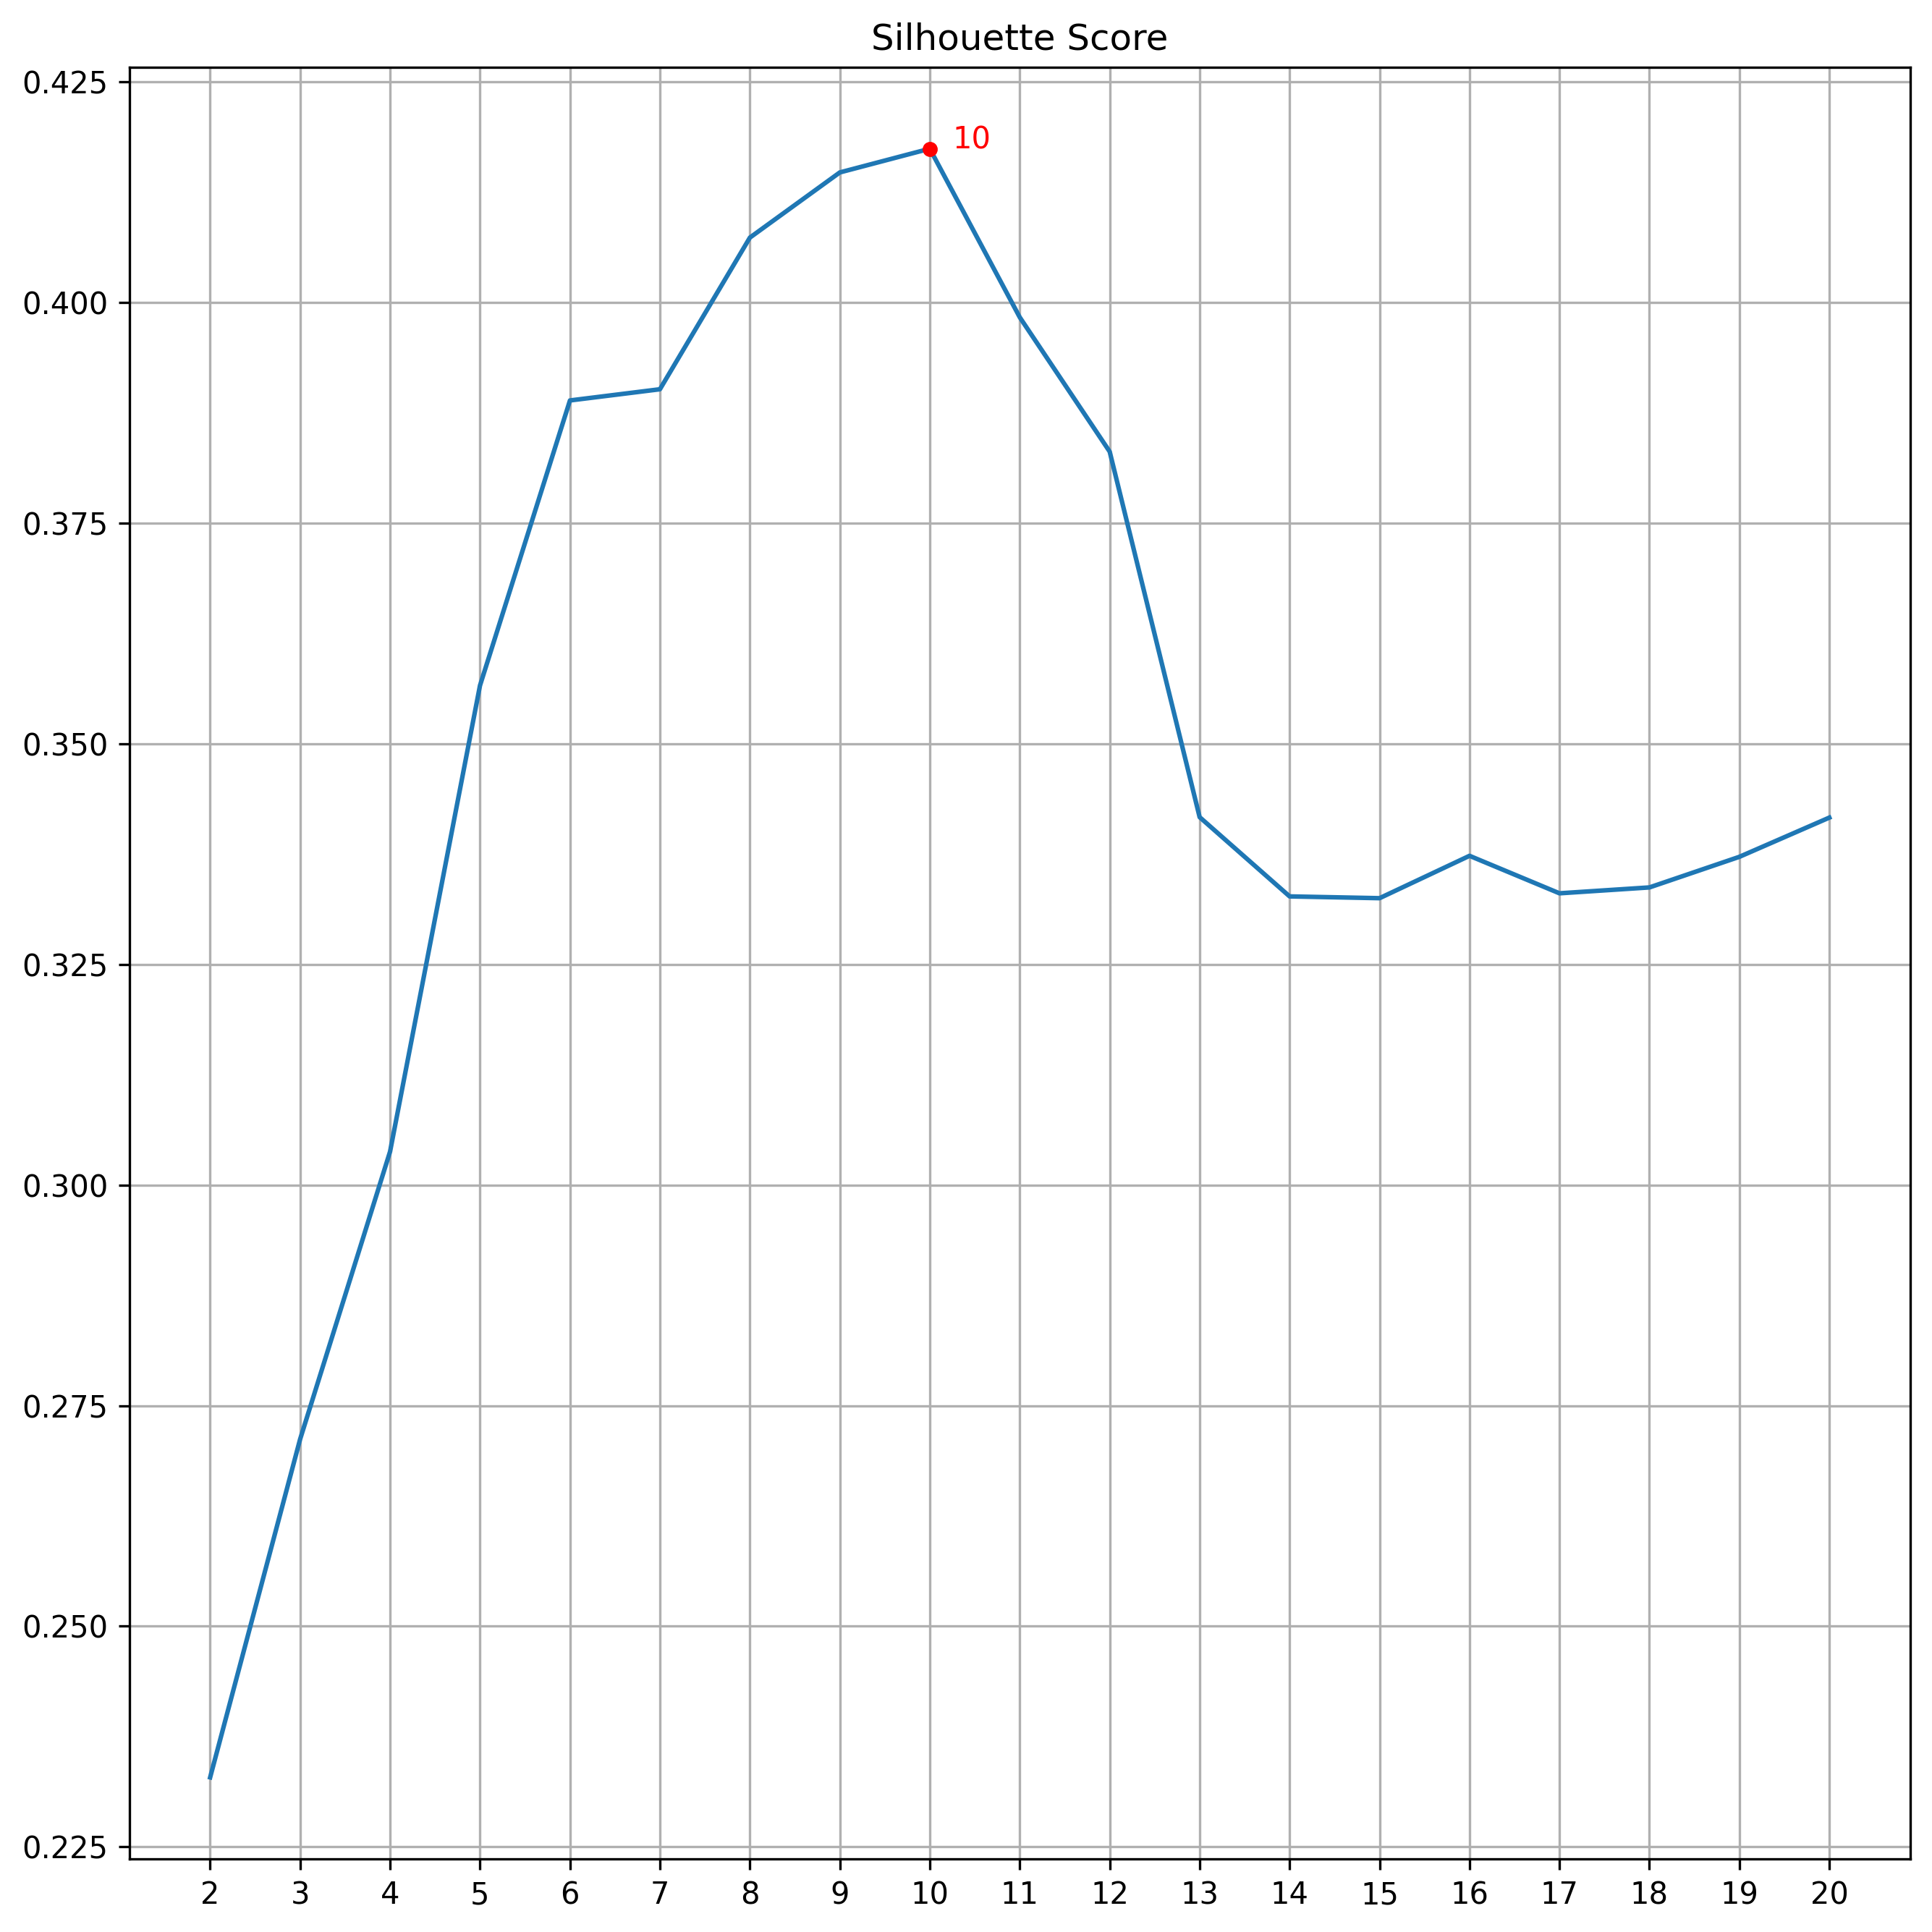

In [11]:
# Clustering cavities
scores = []

# Calculate distance between cavity grids
distance = squareform(pdist(cavities, 'correlation'))

print(distance.shape)

# Explore number of clusters
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for n_cluster in n_clusters:
    preds = AgglomerativeClustering(n_clusters=n_cluster, affinity='precomputed', linkage="complete").fit_predict(distance)
    scores.append(silhouette_score(distance, preds, metric="precomputed"))
    
# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=300, tight_layout=True, clear=True)
ax.plot(n_clusters, scores)
ax.plot(n_clusters[numpy.argmax(scores)], scores[numpy.argmax(scores)], marker='o', color='red', markersize=4)
ax.annotate(n_clusters[numpy.argmax(scores)], (n_clusters[numpy.argmax(scores)]+0.25, scores[numpy.argmax(scores)]), color='red')
ax.set_title("Silhouette Score")
ax.grid()
ax.set_xticks(n_clusters)
plt.savefig("results/HIV/grid/silhouette-score.png", dpi=300)
plt.show()

#### Agglomerative clustering based on Silhouette Scores

In [16]:
preds = AgglomerativeClustering(n_clusters=10, affinity='correlation', linkage="complete").fit_predict(cavities)

In [17]:
# Plot silhouette
KVFinderMD.silhouette(
    cavities, 
    preds,
    metric='correlation',
    filename='results/HIV/grid/silhouette.png'
)

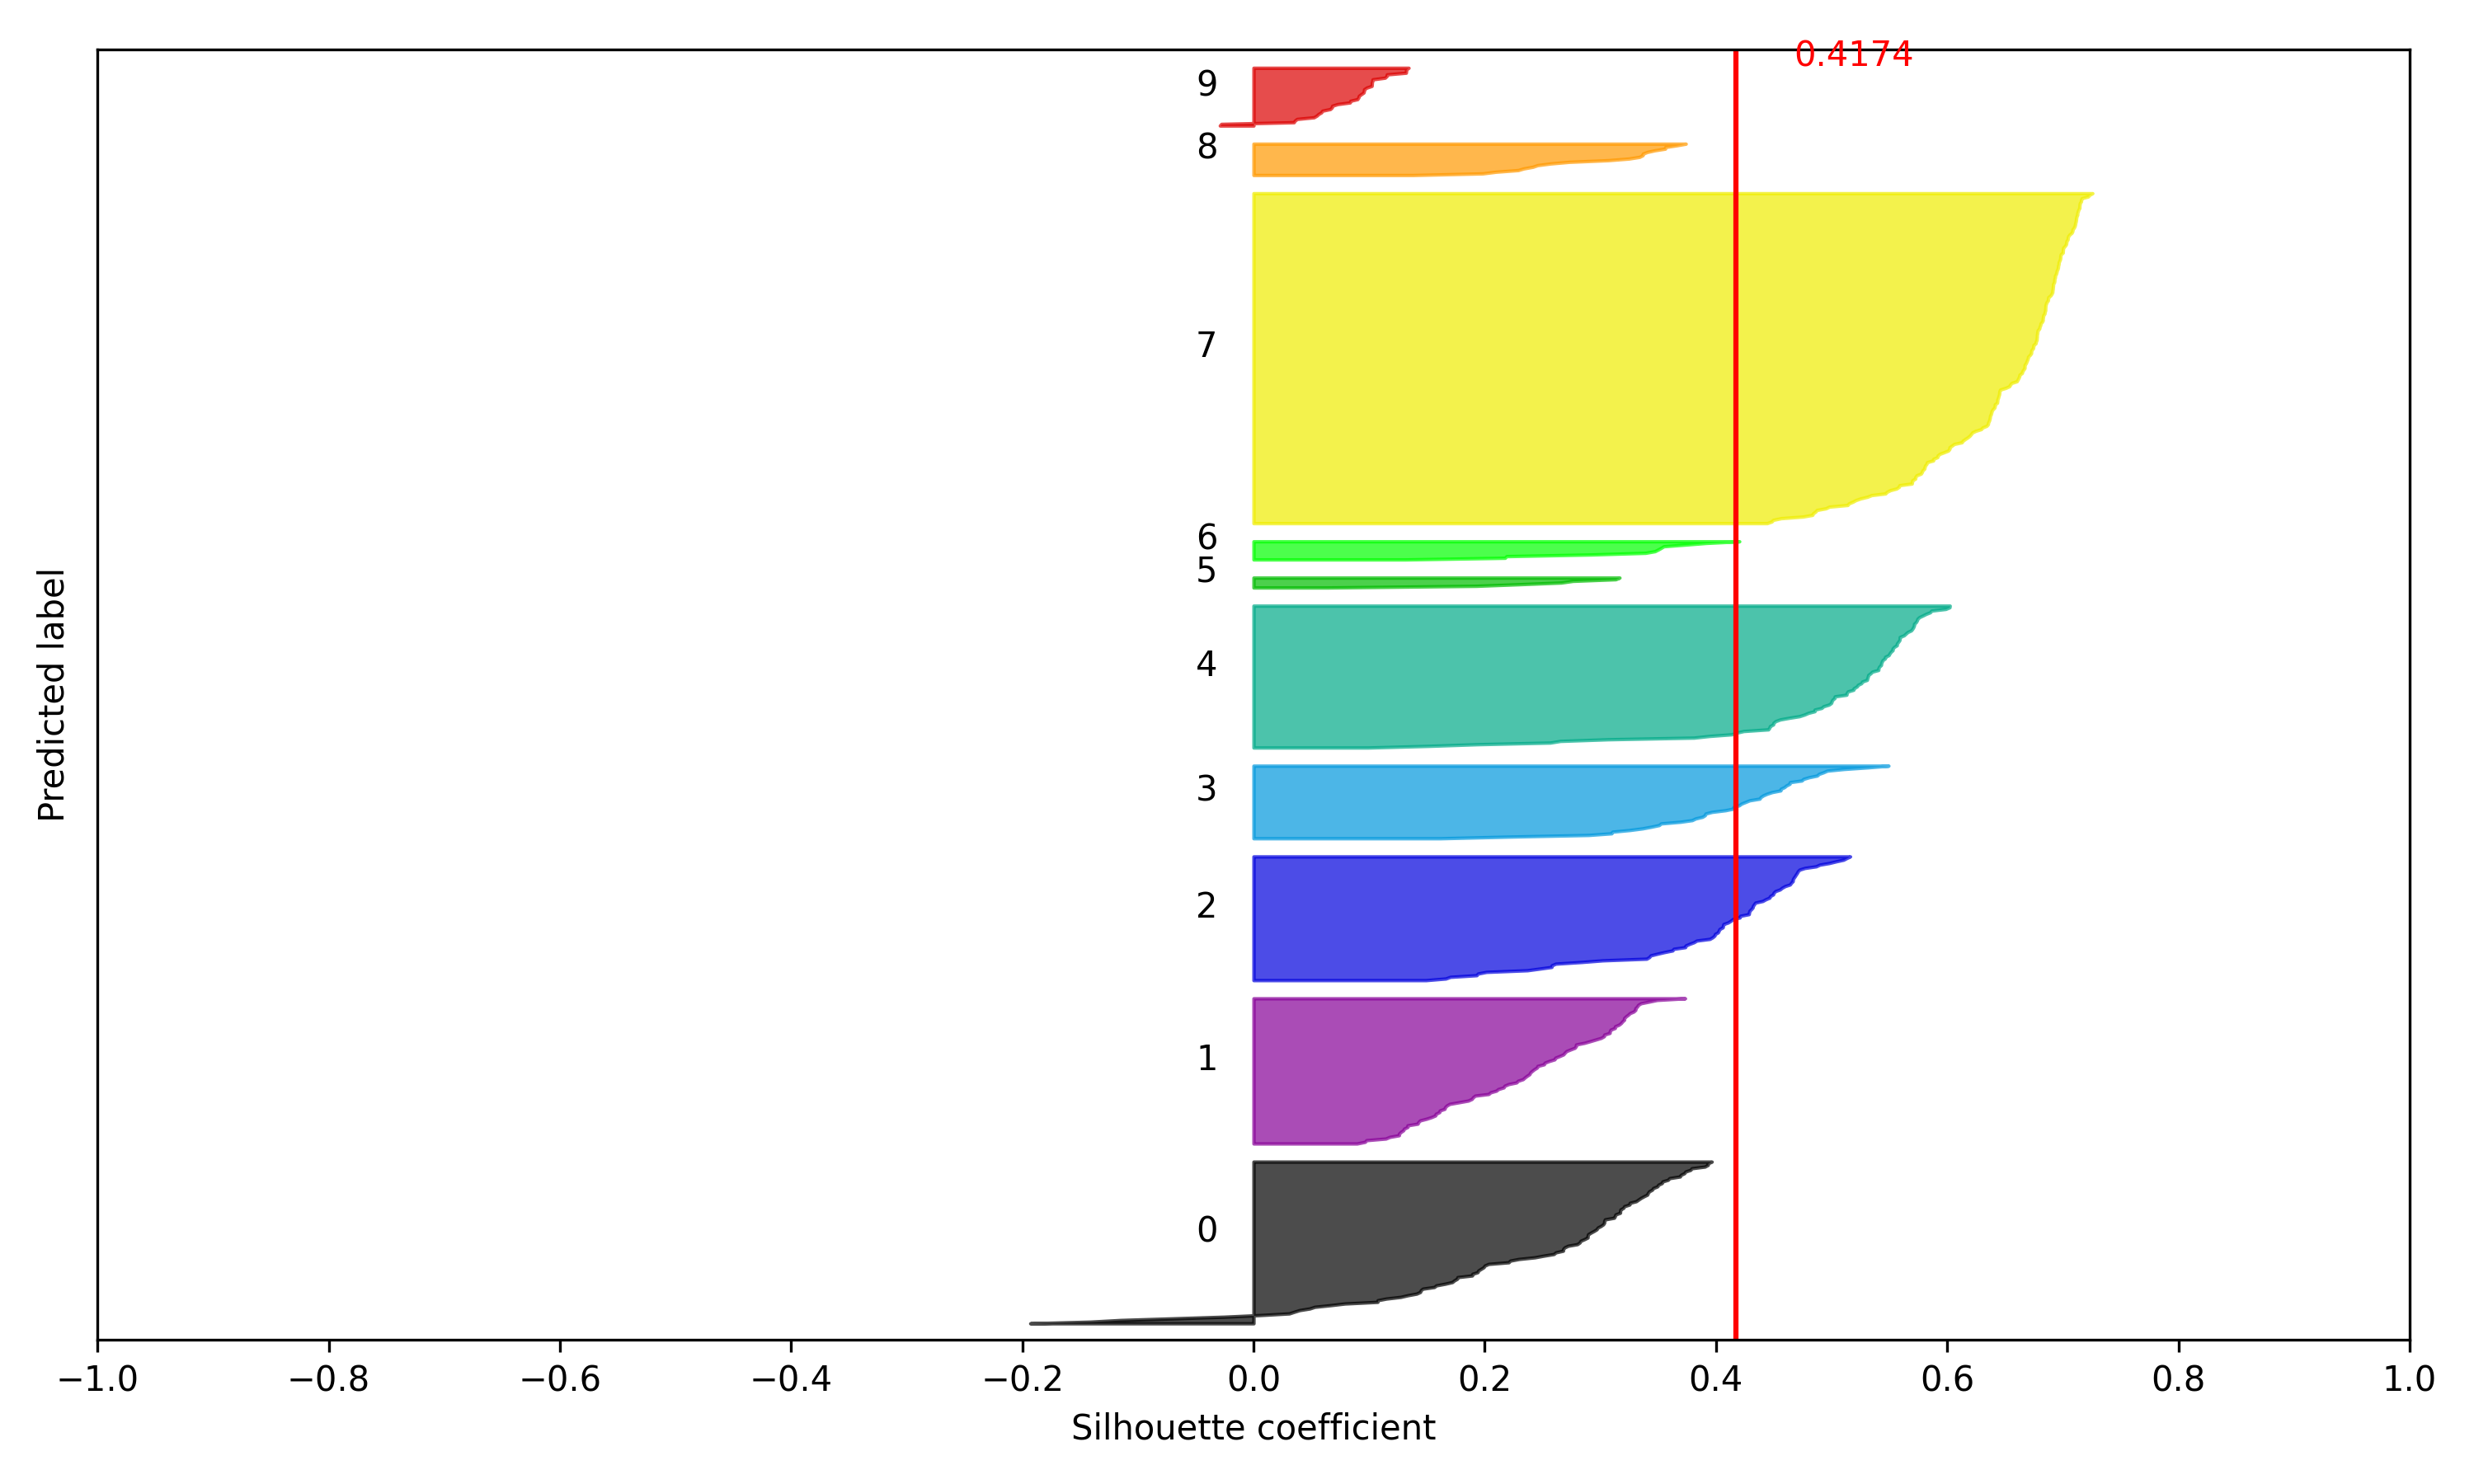

In [18]:
IPython.display.Image("results/HIV/grid/silhouette.png")

In [19]:
# Write cavities to file
for i, cav in enumerate(cavities):
    cav = cav.reshape(160, 126, 105)
    B = numpy.ones(cav.shape) * preds[i]
    pyKVFinder.export(
        f'results/HIV/grid/cavity-{i:03d}.pdb', 
        cav.astype(int) * 2, 
        None,
        md.kvtraj._vertices,
        md.kvtraj._step,
        B=B
    )

In [20]:
# Visualize cavity clusters

# Define colors
colors = [mpl.cm.nipy_spectral(float(i) / (preds.max()+1)) for i in range(preds.max()+1)]
print(dict(zip(range(preds.max()+1), colors)))

# Create NGL Viewer widget
view = nglview.NGLWidget(gui=True)

# Display trajectory
pdb = view.add_component('data/HIV.pdb')
pdb.clear()
pdb.add_cartoon(color='gray')

# Display occurrence of cavity points
cavs = []

for i in range(cavities.shape[0]):
    cavs.append(view.add_component(f'results/HIV/grid/cavity-{i:03d}.pdb'))
    cavs[i].clear()
#     cavs[i].add_point(color=mpl.colors.to_hex(colors[preds[i]]))
    cavs[i].add_surface(color=mpl.colors.to_hex(colors[preds[i]]), opacity=0.5)

# Display on NGL viewer
view

{0: (0.0, 0.0, 0.0, 1.0), 1: (0.5306882352941177, 0.0, 0.5973843137254902, 1.0), 2: (0.0, 0.0, 0.8667, 1.0), 3: (0.0, 0.5947725490196079, 0.8667, 1.0), 4: (0.0, 0.6667, 0.5333, 1.0), 5: (0.0, 0.7385313725490196, 0.0, 1.0), 6: (0.0, 1.0, 0.0, 1.0), 7: (0.9359156862745098, 0.9280725490196079, 0.0, 1.0), 8: (1.0, 0.6, 0.0, 1.0), 9: (0.8640843137254902, 0.0, 0.0, 1.0)}


NGLWidget()

In [21]:
# Download image
view.download_image('HIV-grid-clustering-10.png', factor=10, trim=True, transparent=True)

### (2D) Contact matrices alignment: clustering contact matrix of each cavity detected throughout the molecular dynamics simulation

Here, we define a contact matrix for each cavity, considering the interface residues surrounding it.

#### Show cavities represented by graphs

In [41]:
# Detect and characterize frame 177
frame = md.frame(176)

# Get interface residues
residues = frame._residues['KAB']

# Get atomic information
atomic = frame.atomic.astype('<U32')

# CA
G177 = SERD.r2g(residues, atomic, "CA", 10.0)
SERD.g2pdb(G177, atomic, residues, 'results/HIV/cavity-177-KAB-CA.pdb')

# CB
G177 = SERD.r2g(residues, atomic, "CB", 8.0)
SERD.g2pdb(G177, atomic, residues, 'results/HIV/cavity-177-KAB-CB.pdb')

# All atoms
G177 = SERD.r2g(residues, atomic, "all", 5.0)
SERD.g2pdb(G177, atomic, residues, 'results/HIV/cavity-177-KAB-all.pdb')

In [40]:
# Visualize cavity
view = nglview.NGLWidget()

# Add graph
CA = view.add_component('results/HIV/cavity-177-KAB-CA.pdb')
CA.clear()
CA.add_representation("ball+stick", color="red")
CB = view.add_component('results/HIV/cavity-177-KAB-CB.pdb')
CB.clear()
CB.add_representation("ball+stick", color="blue")
all = view.add_component('results/HIV/cavity-177-KAB-all.pdb')
all.clear()
all.add_representation("ball+stick", color="magenta")

# Display on NGL viewer
view

NGLWidget()

In [42]:
# PyMOL v2.5.0: Visualize cavity as graphs
os.makedirs("pymol/HIV/", exist_ok=True)

with open("pymol/HIV/visualize-graphs.py", "w") as f:
    f.write(f"""import pymol

pymol.finish_launching(['pymol', '-q'])

# Load trajectory
cmd.load("data/HIV.pdb")
cmd.load("results/HIV/cavity-177-KAB-CA.pdb", "CA")
cmd.load("results/HIV/cavity-177-KAB-CB.pdb", "CB")
cmd.load("results/HIV/cavity-177-KAB-all.pdb", "atom")


# Select interface residues
cmd.set("state", 177)
cmd.select("graph", f"obj CA or CB or atom")
cmd.hide("everything", "graph")
cmd.show("sticks", "graph")
cmd.color("red", "obj CA")
cmd.color("blue", "obj CB")
cmd.color("magenta", "obj atom")

cmd.orient()
""")

# Run script in pymol    
os.system(f"pymol pymol/HIV/visualize-graphs.py")

 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected OpenGL version 4.6. Shaders available.
 Detected GLSL version 4.60.
 OpenGL graphics engine:
  GL_VENDOR:   NVIDIA Corporation
  GL_RENDERER: NVIDIA GeForce RTX 3060/PCIe/SSE2
  GL_VERSION:  4.6.0 NVIDIA 515.65.01
 Detected 12 CPU cores.  Enabled

 parser: matching files:
  documentation/figures/HIV-cavity-177-KAB-CA.png                  
  documentation/figures/HIV-cavity-177-KAB-CB.png                  
  documentation/figures/HIV-cavity-177-KAB-all.png                 
  documentation/figures/HIV-cavity-177-KAB.png                     
  documentation/figures/HIV-cavity-177.png                         
  documentation/figures/HIV-constitutional-characterization-1.png  
  documentation/figures/HIV-constitutional-characterization-177.png
  documentation/figures/HIV-grid-clustering-10.png                 
  documentation/figures/HIV-hydropathy-characterization-1.png      
  documentation/figures/HIV-hydropathy-characterization-177.png    
  documentation/figures/HIV-spatial-conservation-1.png             
  documentation/figures/HIV-spatial-conservation-2.png             
  documentation/figures/HIV-spatial-depth-characterization-1.png   
  documentation/figures/HIV-spatial-depth-characterization-177.png 
 parser: matching files

0

#### Distance matrix of cavity KAB in frame 177

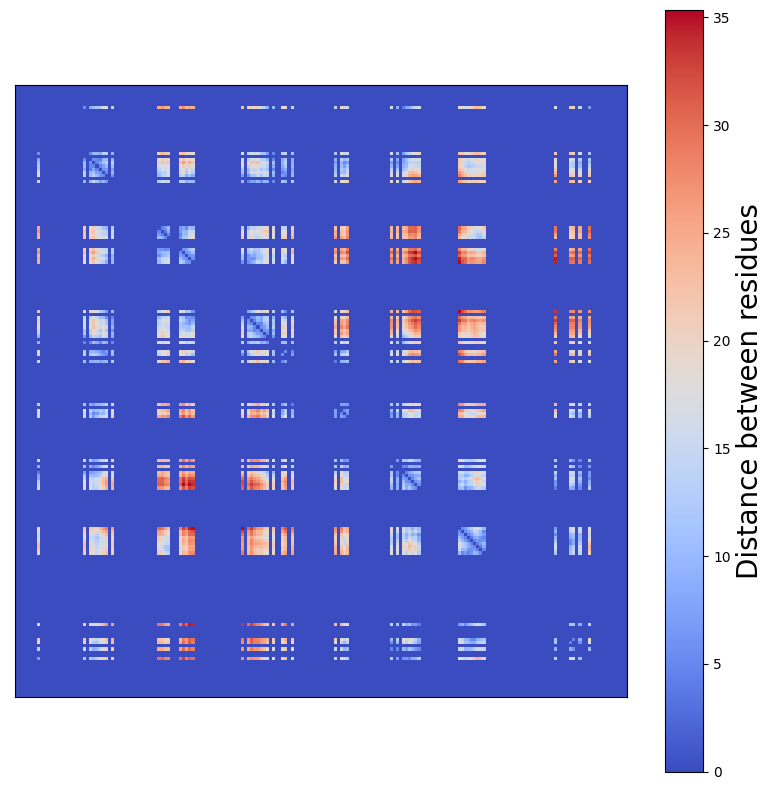

In [25]:
# Distance matrix
distance_matrix = KVFinderMD.distance_matrix(atomic, residues, selection="CB")

# Prepare figure
fig, ax = plt.subplots(figsize=(8,8), clear=True, tight_layout=True)

plt.imshow(distance_matrix, cmap='coolwarm')
ax.axis("on")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# Colorbar
cb = plt.colorbar()
cb.set_label('Distance between residues', size=20)

plt.savefig("results/HIV/distance-matrix-176.svg", dpi=300)

plt.show()

#### Contact matrix of cavity KAB in frame 177

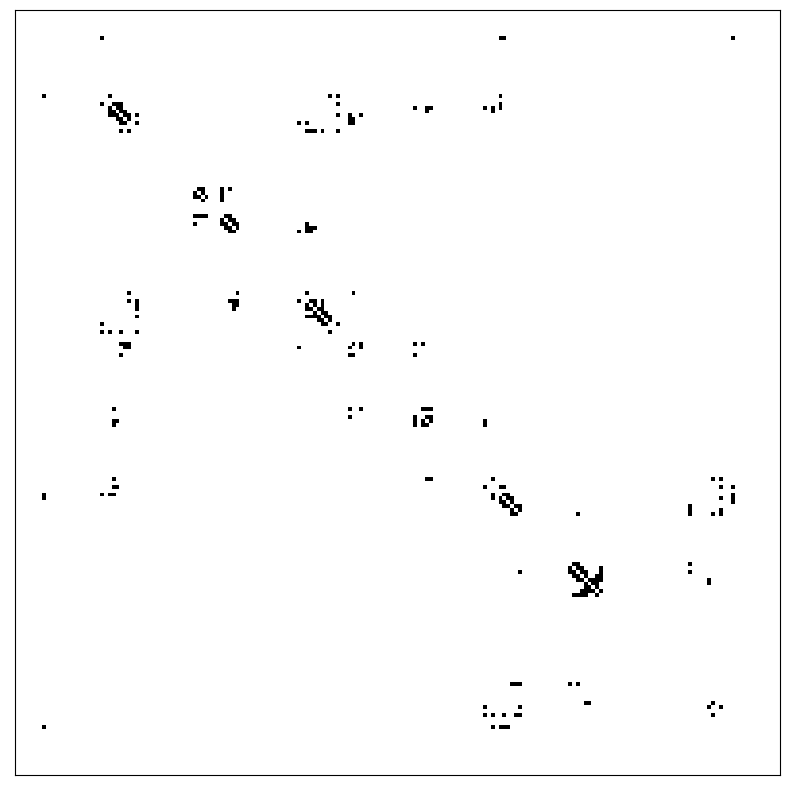

In [26]:
# Contact matrix
contact_matrix = KVFinderMD.contact_matrix(distance_matrix, selection="CB")

# Prepare figure
fig, ax = plt.subplots(figsize=(8,8), clear=True, tight_layout=True)

plt.imshow(contact_matrix, cmap='binary')
ax.axis("on")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.savefig("results/HIV/contact-matrix-176.svg", dpi=300)

plt.show()

#### Explore distance metrics in 2D comparison of contact matrices

The distance metrics are used to assess the similarity of the adjacency matrices, ie the detected cavities.

The standard metrics: 
- Euclidean distance
- Correlation

Pairwise distances for booleans:
- Dice dissimilarity
- Hamming distance
- Jaccard dissimilarity
- Kulsinki dissimilarity
- Rogers-Tanimoto dissimilarity
- Russell-Rao dissimilarity
- Sokal-Michener dissimilarity
- Sokal-Sneath dissimilarity
- Yule dissimilarity

Discussion about those metrics:
- https://www.ibm.com/docs/en/spss-statistics/SaaS?topic=measures-distances-similarity-binary-data
- https://stats.stackexchange.com/questions/61705/similarity-coefficients-for-binary-data-why-choose-jaccard-over-russell-and-rao

In [27]:
# Create CavityAlignment object
alignment = KVFinderMD.CavityAlignment(md)

In [28]:
# Explore contact matrix alignment
alignment.explore(method="contact")

In [29]:
alignment.scores

,Number of Clusters,Silhouette Score
Correlation,11.0,0.557755
Dice,16.0,0.524279
Hamming,2.0,0.622585
Jaccard,16.0,0.401248
Kulsinki,7.0,0.001522
Rogers-Tanimoto,2.0,0.621012
Rusell-Rao,8.0,0.001496
Sokal-Michener,2.0,0.621012
Sokal-Sneath,16.0,0.279258
Yule,16.0,0.811657


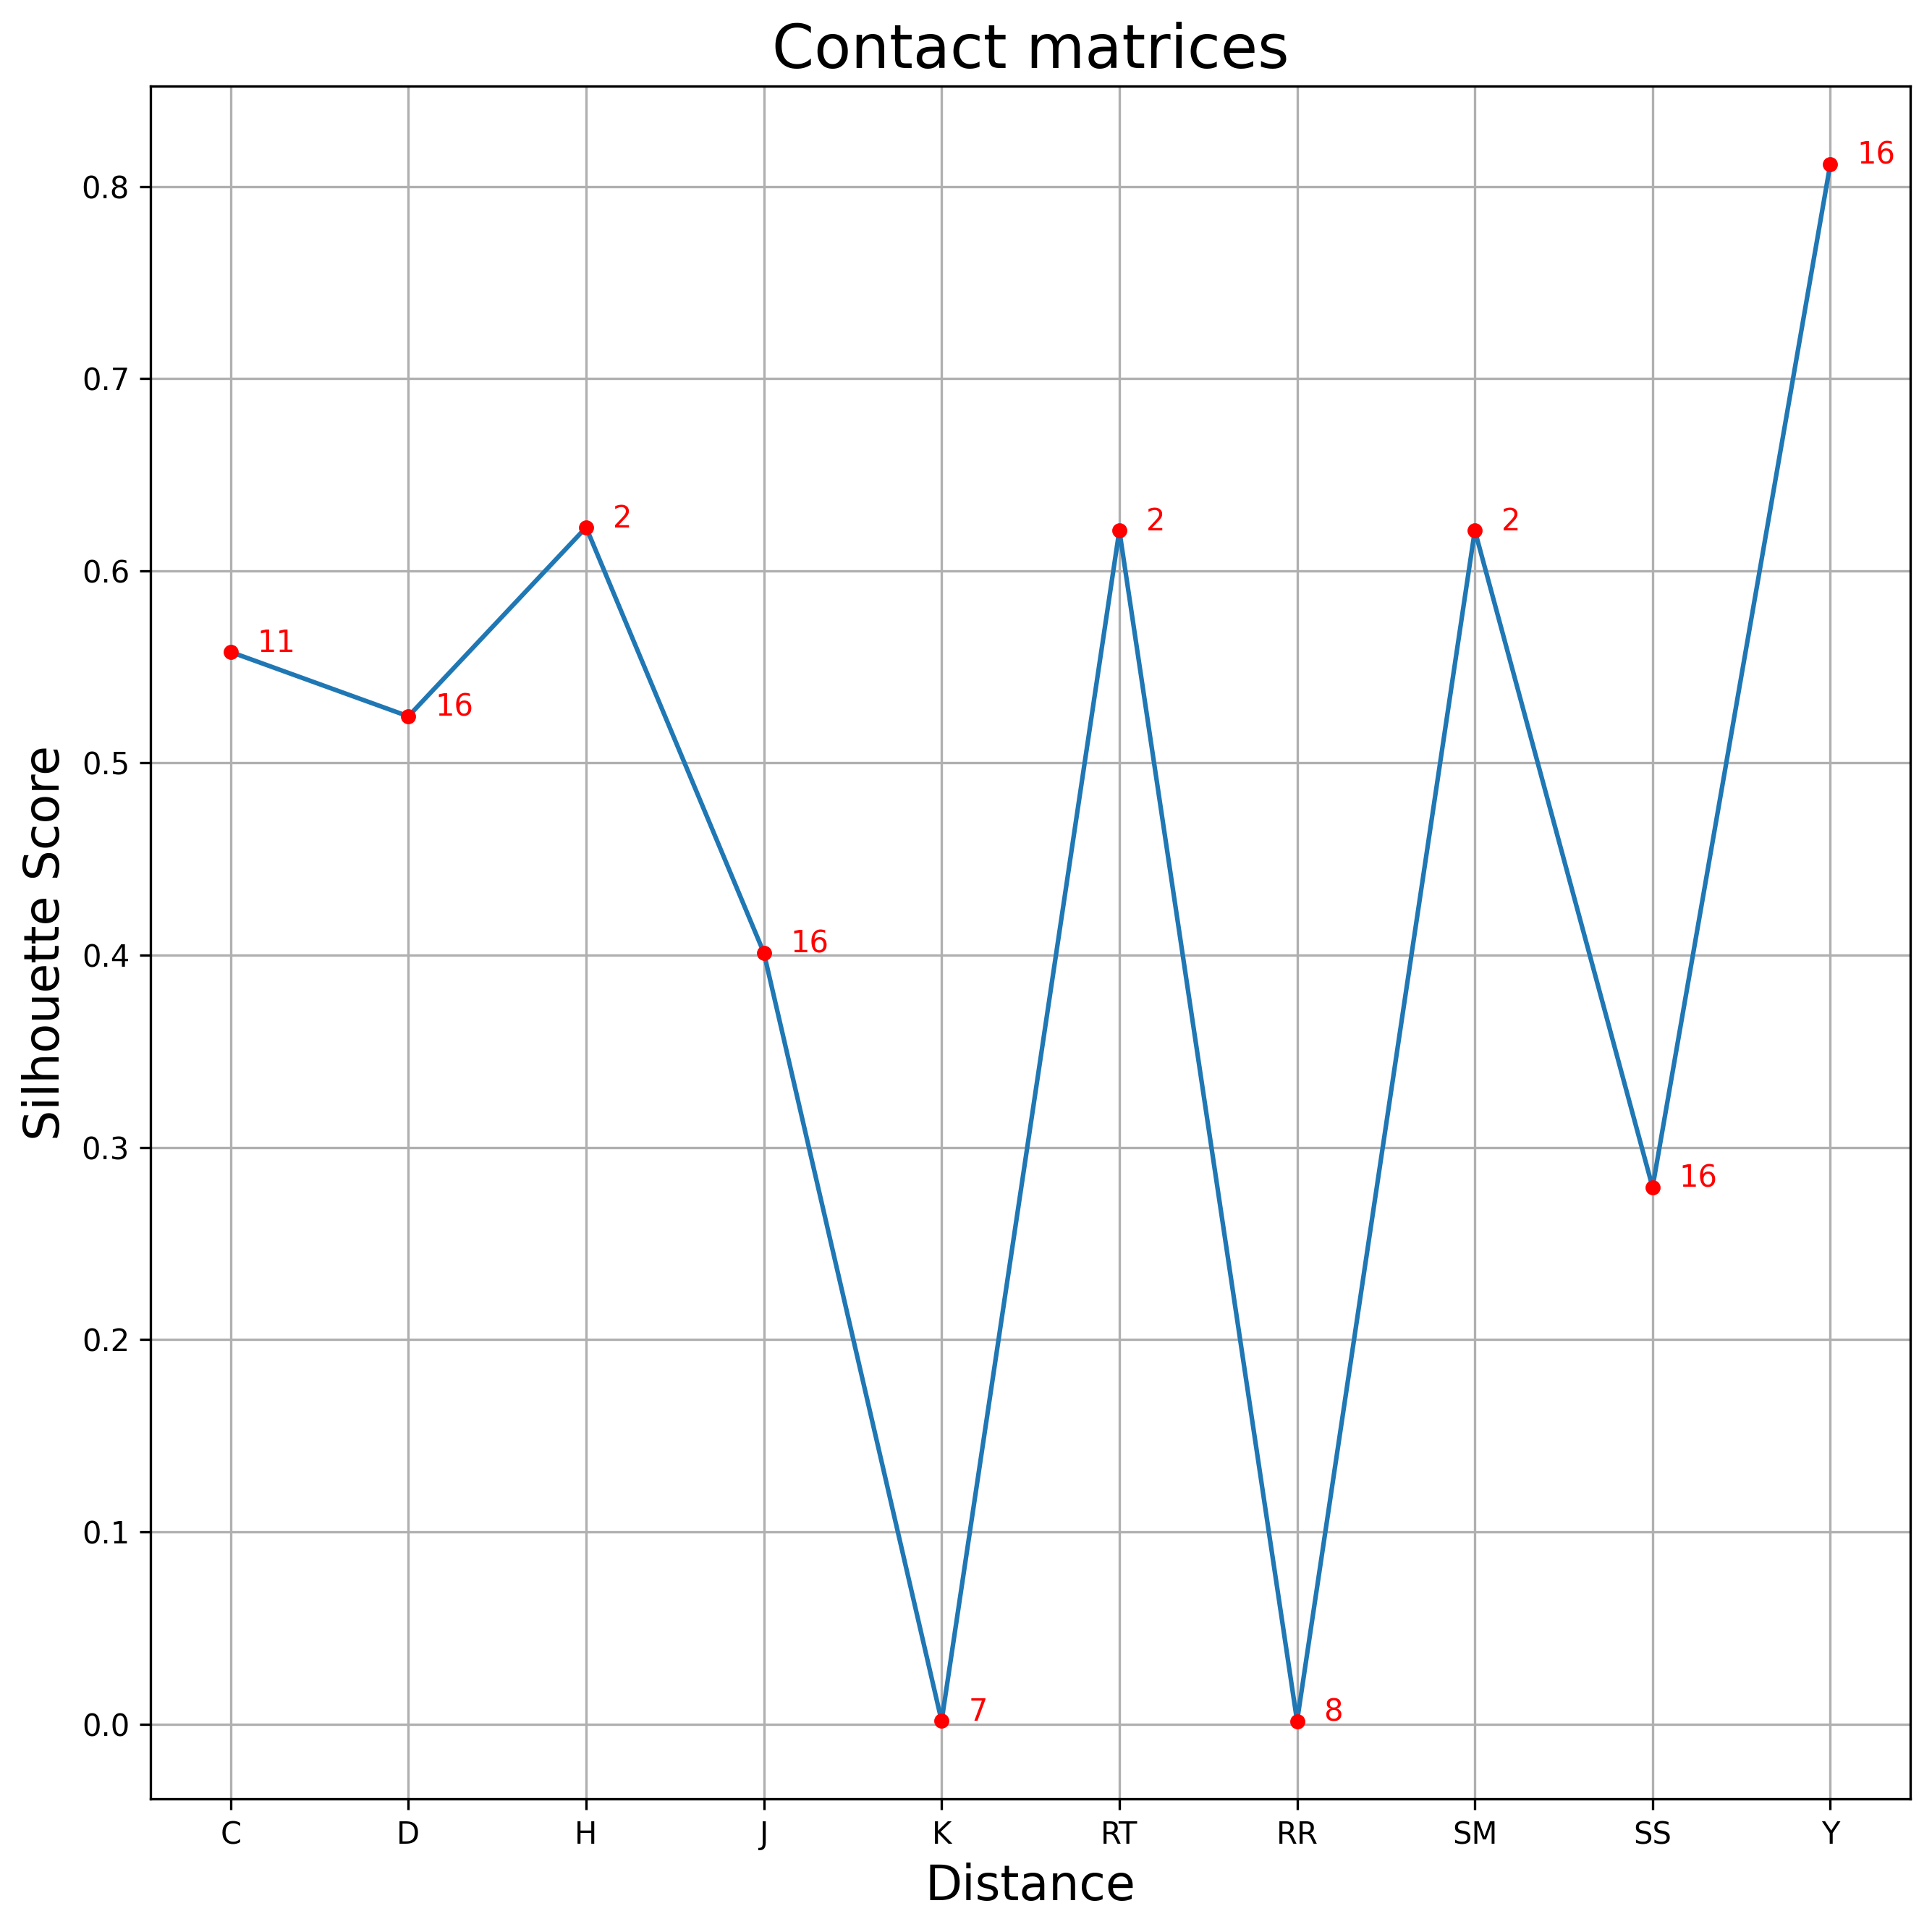

In [30]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=300, tight_layout=True, clear=True)
captions = ['C', 'D', 'H', 'J', 'K', 'RT', 'RR', 'SM', 'SS', 'Y']

# Line plot
ax.plot(captions, alignment.scores['Silhouette Score'].values)

# Plot points and text
for x, score, n_cluster in zip(
    numpy.arange(0, 10), 
    alignment.scores['Silhouette Score'].values, 
    alignment.scores['Number of Clusters'].values
):
    ax.plot(x, score, marker='o', color='red', markersize=4)
    ax.text(x + 0.15, score, int(n_cluster), color='red')

ax.grid()
ax.set_title("Contact matrices", size=20)
ax.set_ylabel("Silhouette Score", size=16)
ax.set_xlabel("Distance", size=16)

plt.savefig("results/HIV/contact/silhouette-score.png")

plt.show()

#### Agglomerative clustering based on Silhouette Score

Here, we select the distances that best separate the cavities, that are:
- Dice dissimilarity
- Jaccard dissimilarity
- Sokal-Sneath dissimilarity
- Yule dissimilarity

In [31]:
for affinity in ['dice', 'jaccard', 'sokalsneath', 'yule']:
    
    # Alignment
    alignment.align(method='contact', affinity=affinity)
    
    # Create directory
    os.makedirs(f'results/HIV/contact/{affinity}', exist_ok=True)

    # Plot silhouette
    KVFinderMD.silhouette(
        alignment.contacts.reshape(672, -1),
        alignment.clusters,
        metric=affinity,
        filename=f'results/HIV/contact/{affinity}/silhouette.png'
    )

    # Write cavities to file
    for i, cav in enumerate(cavities):
        cav = cav.reshape(160, 126, 105)
        B = numpy.ones(cav.shape) * alignment.clusters[i]
        pyKVFinder.export(
            f'results/HIV/contact/{affinity}/cavity-{i:03d}.pdb', 
            cav.astype(int) * 2, 
            None, 
            md.kvtraj._vertices, 
            md.kvtraj._step,
            B=B
        )

/home/ABTLUS/joao.guerra/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/home/ABTLUS/joao.guerra/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric dice
  warnings.warn(msg, DataConversionWarning)
/home/ABTLUS/joao.guerra/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/ABTLUS/joao.guerra/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/ABTLUS/joao.guerra/anaconda3/envs/jupyter/lib/python3.9/site-packages/sklearn/metrics/pairwise.p

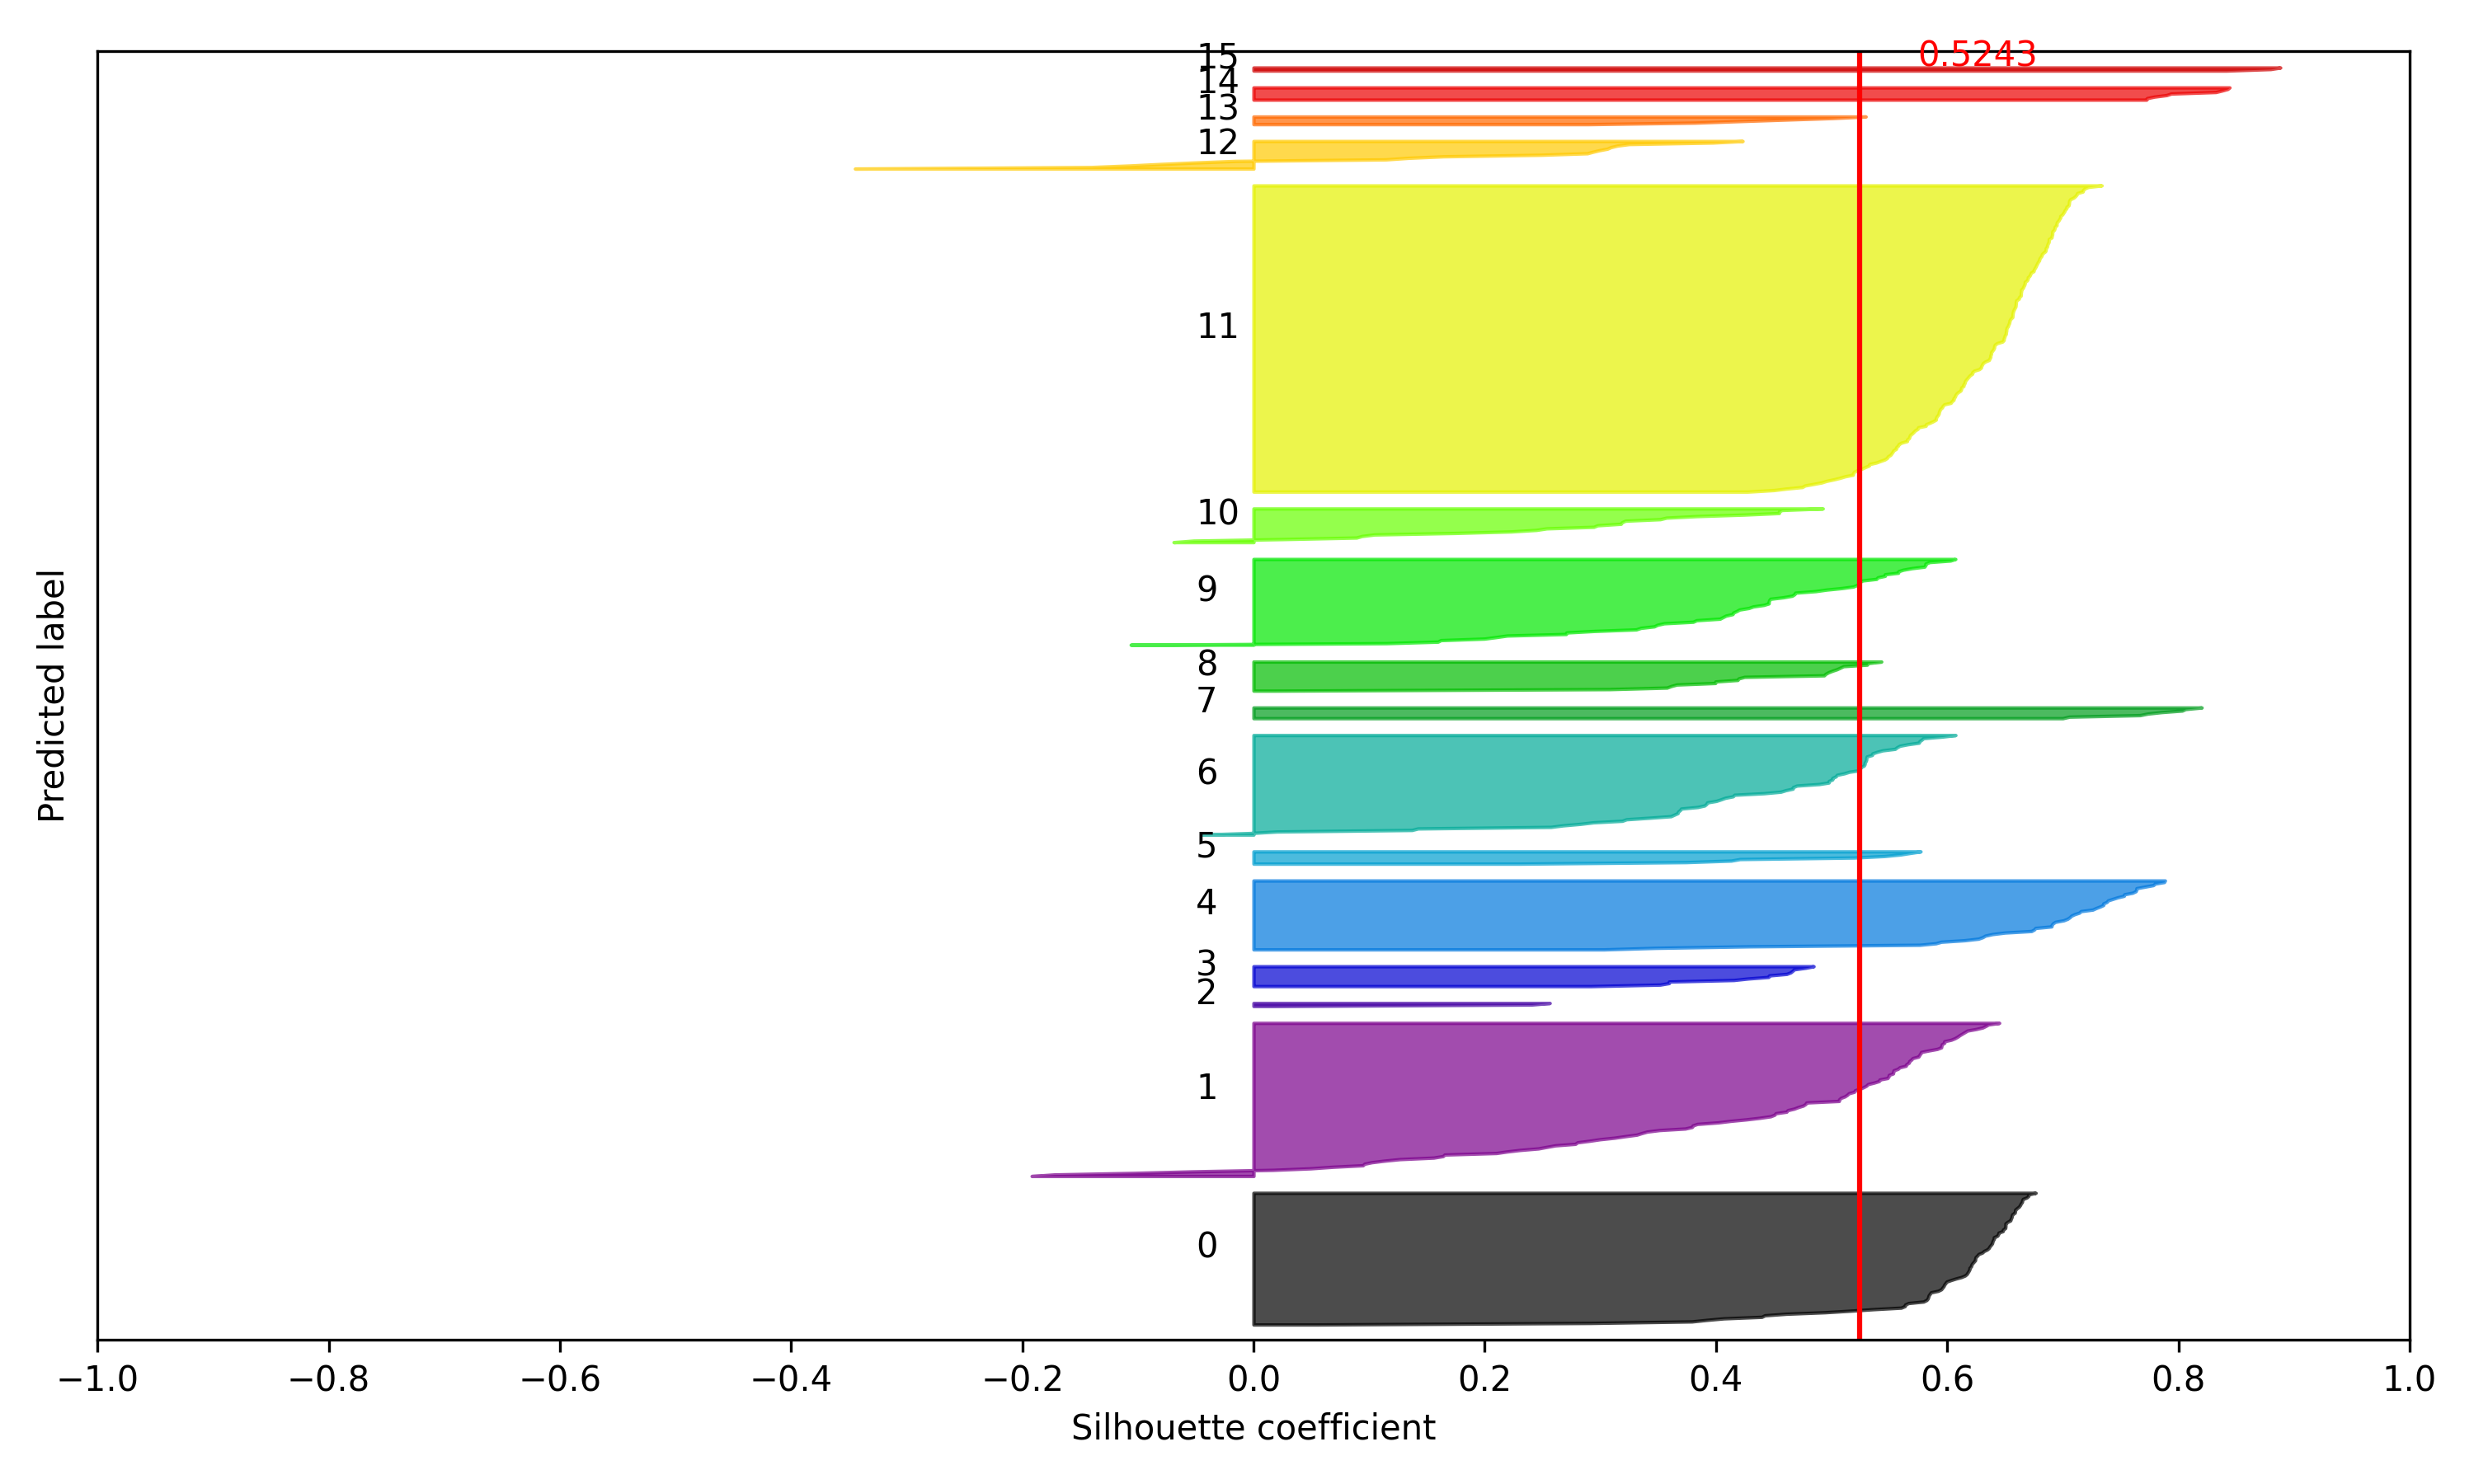

In [32]:
IPython.display.Image("results/HIV/contact/dice/silhouette.png")

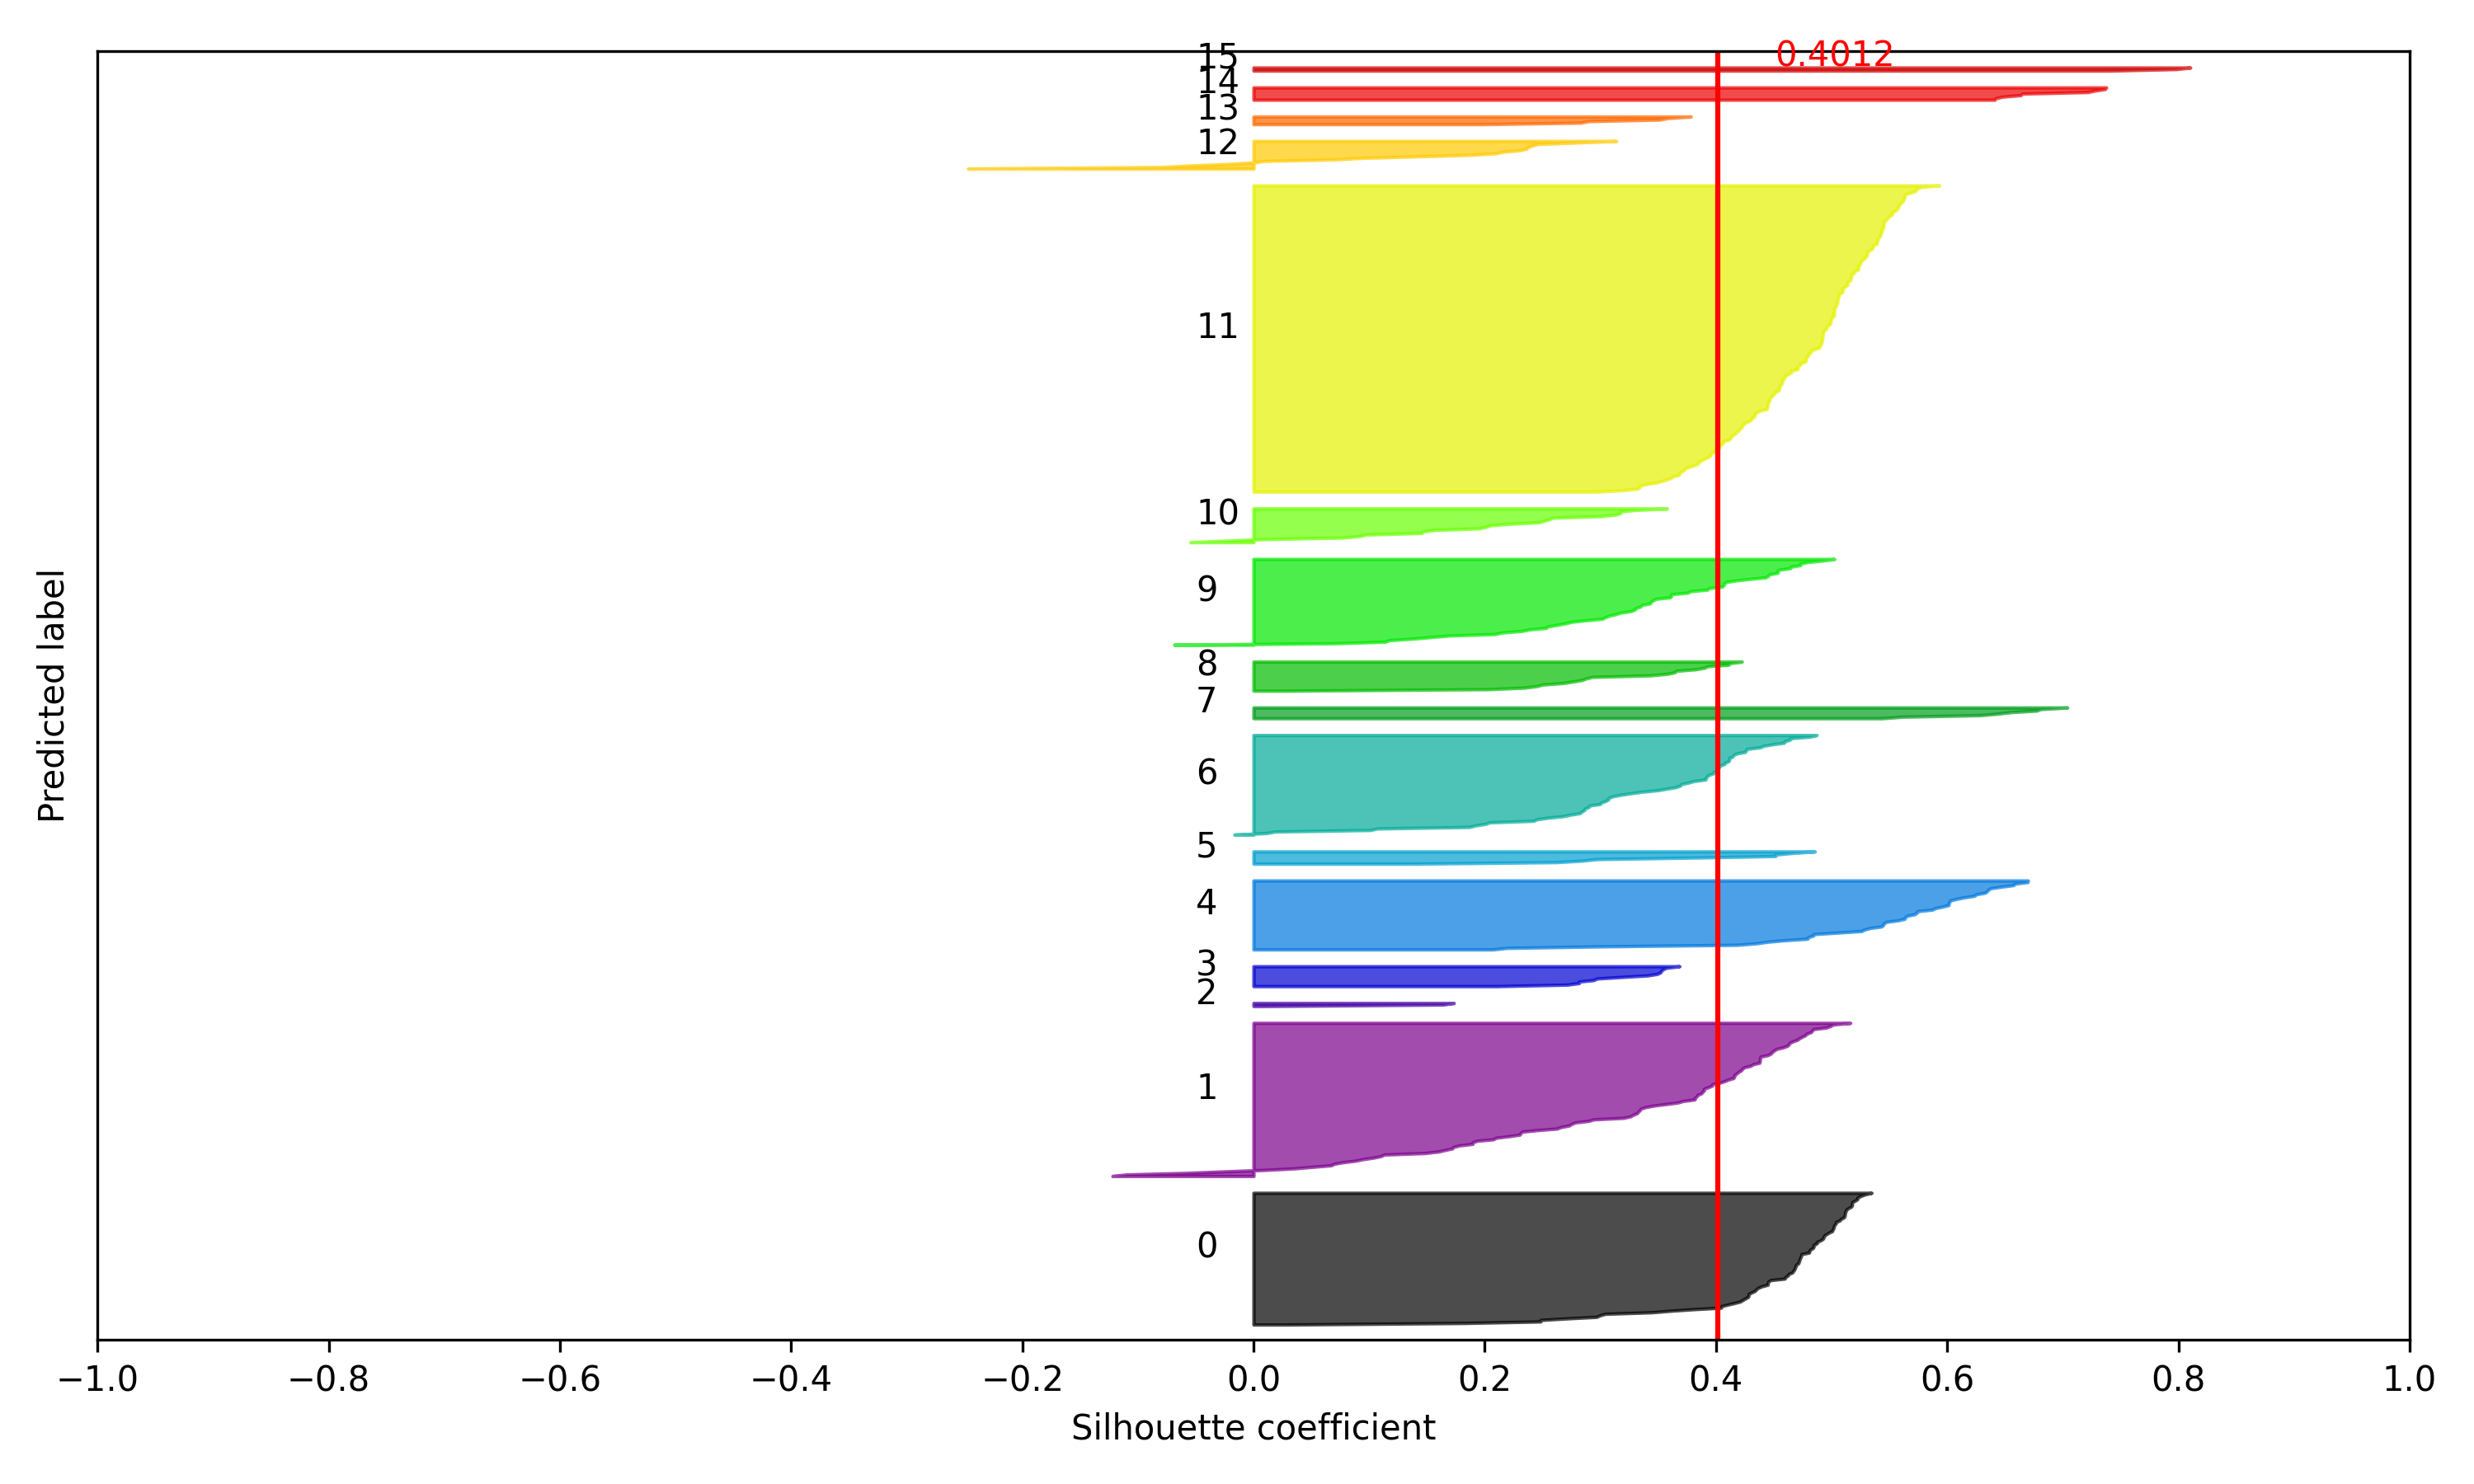

In [33]:
IPython.display.Image("results/HIV/contact/jaccard/silhouette.png")

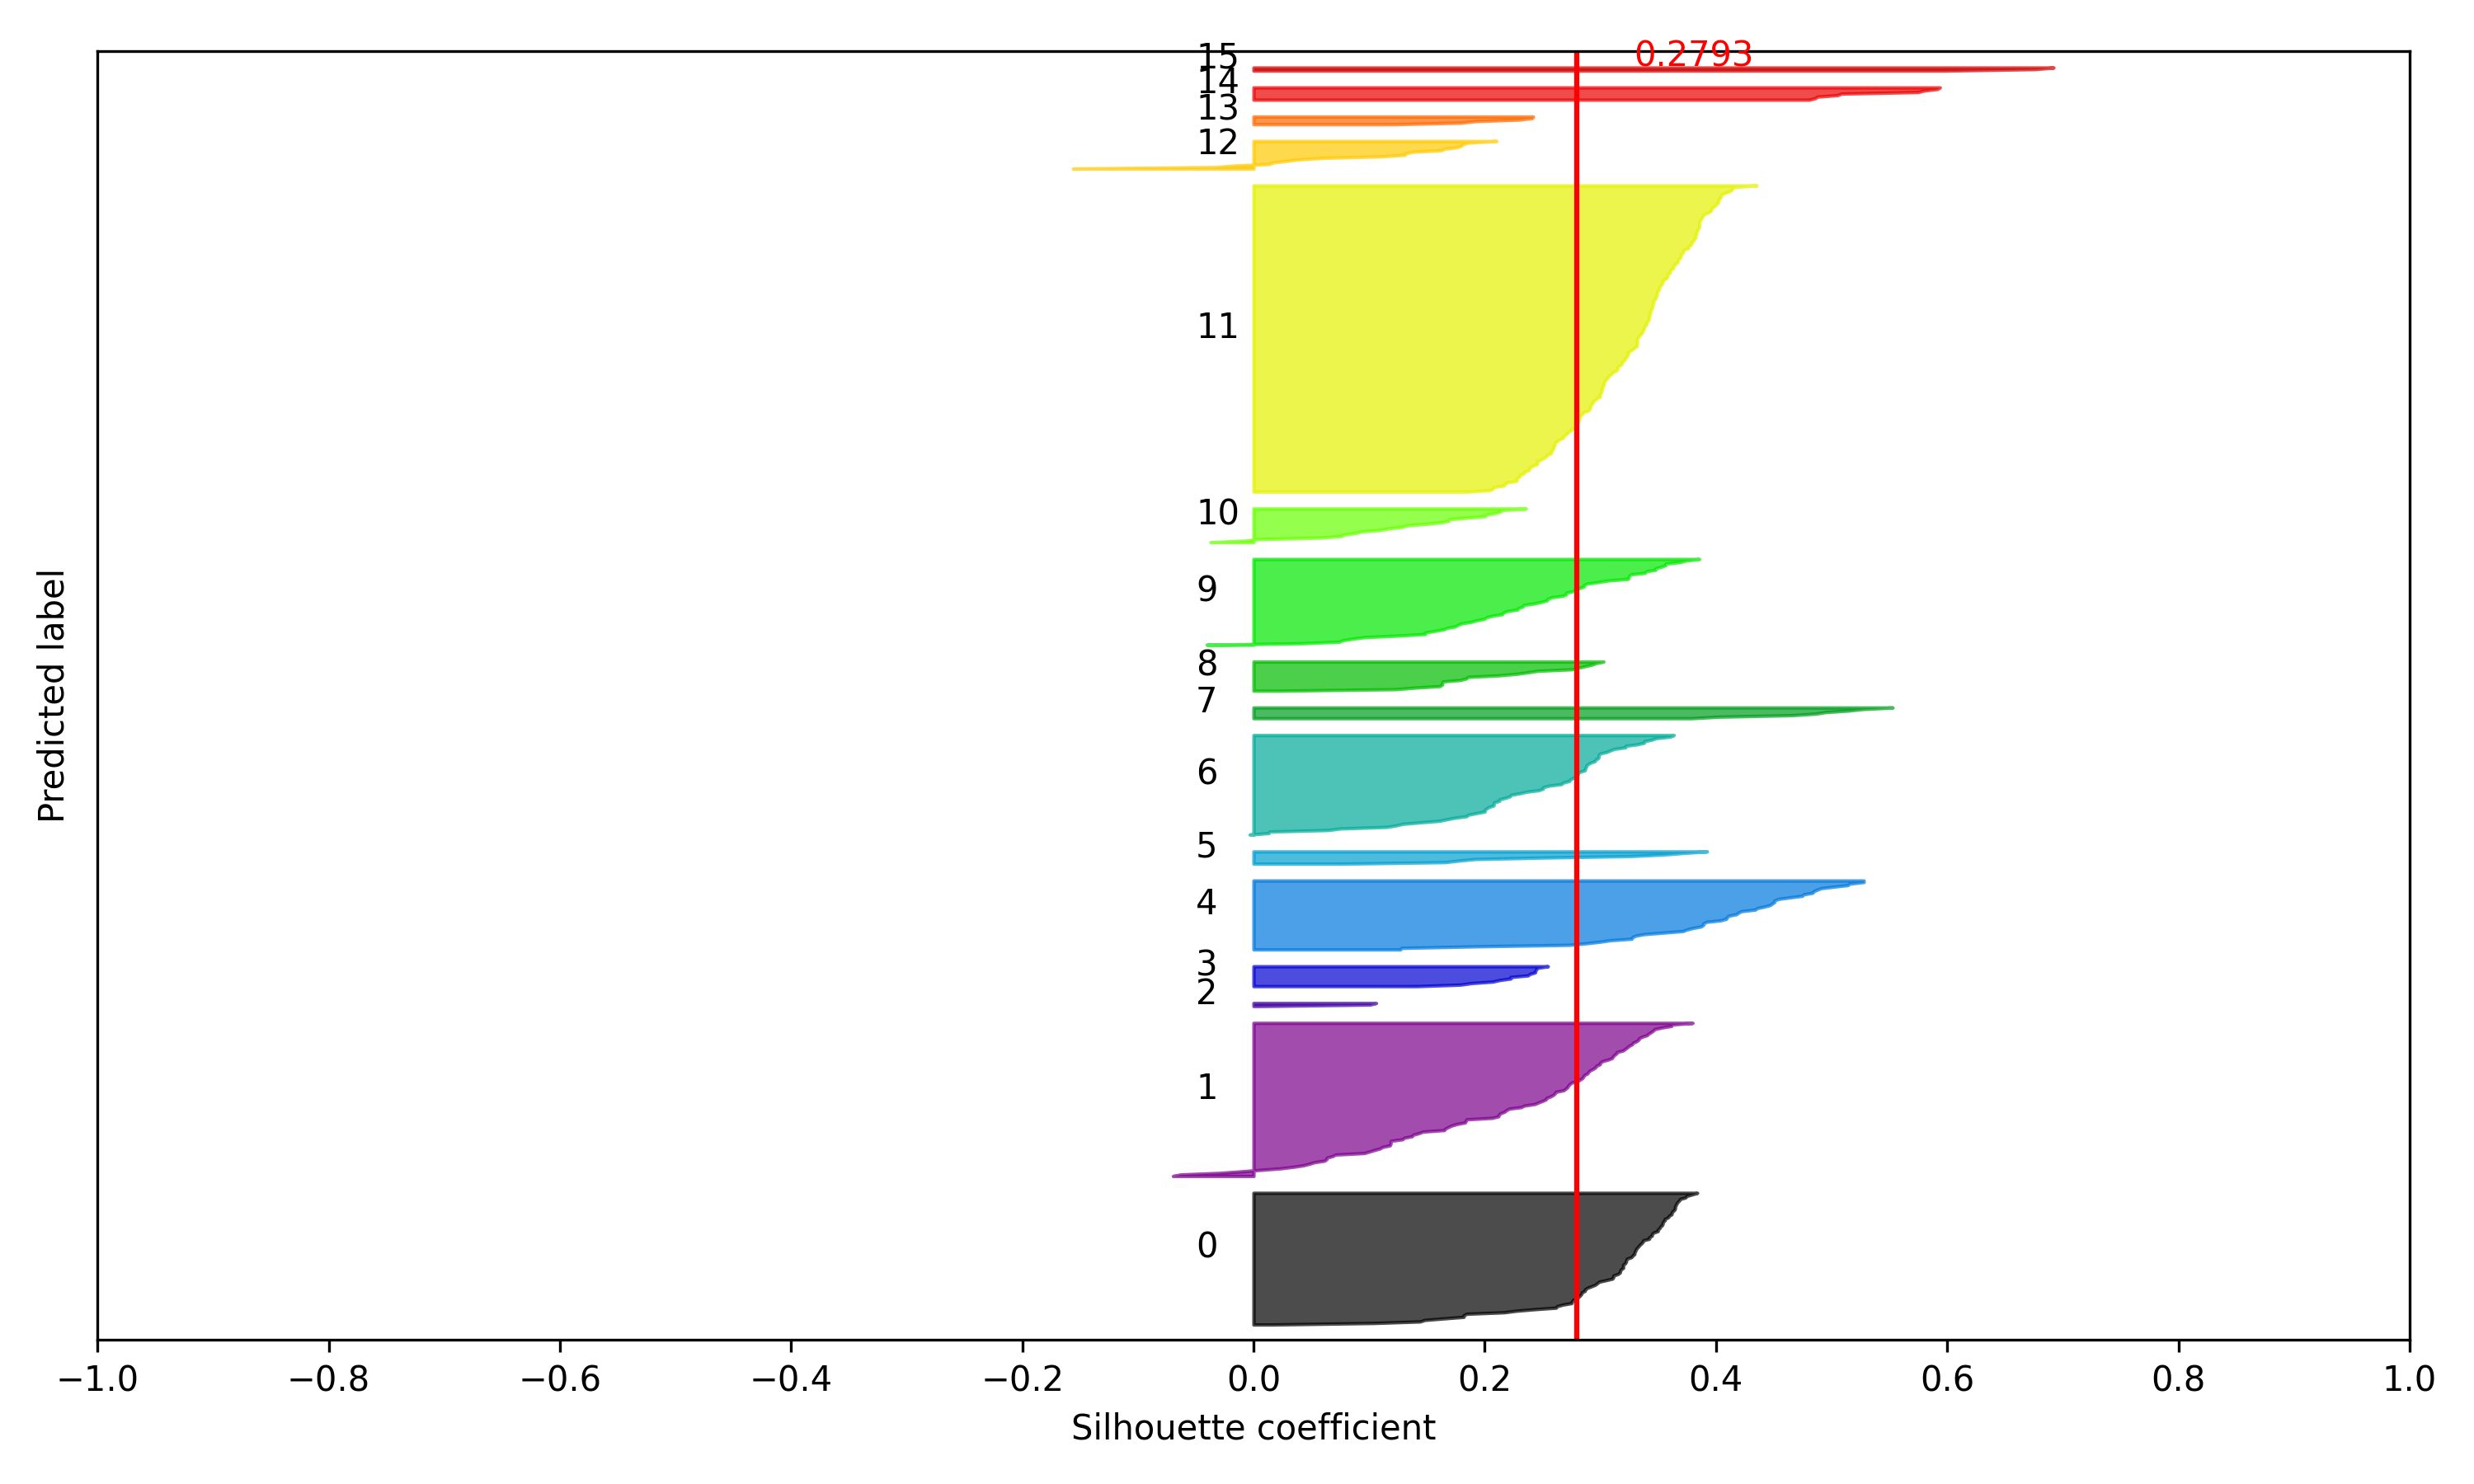

In [34]:
IPython.display.Image("results/HIV/contact/sokalsneath/silhouette.png")

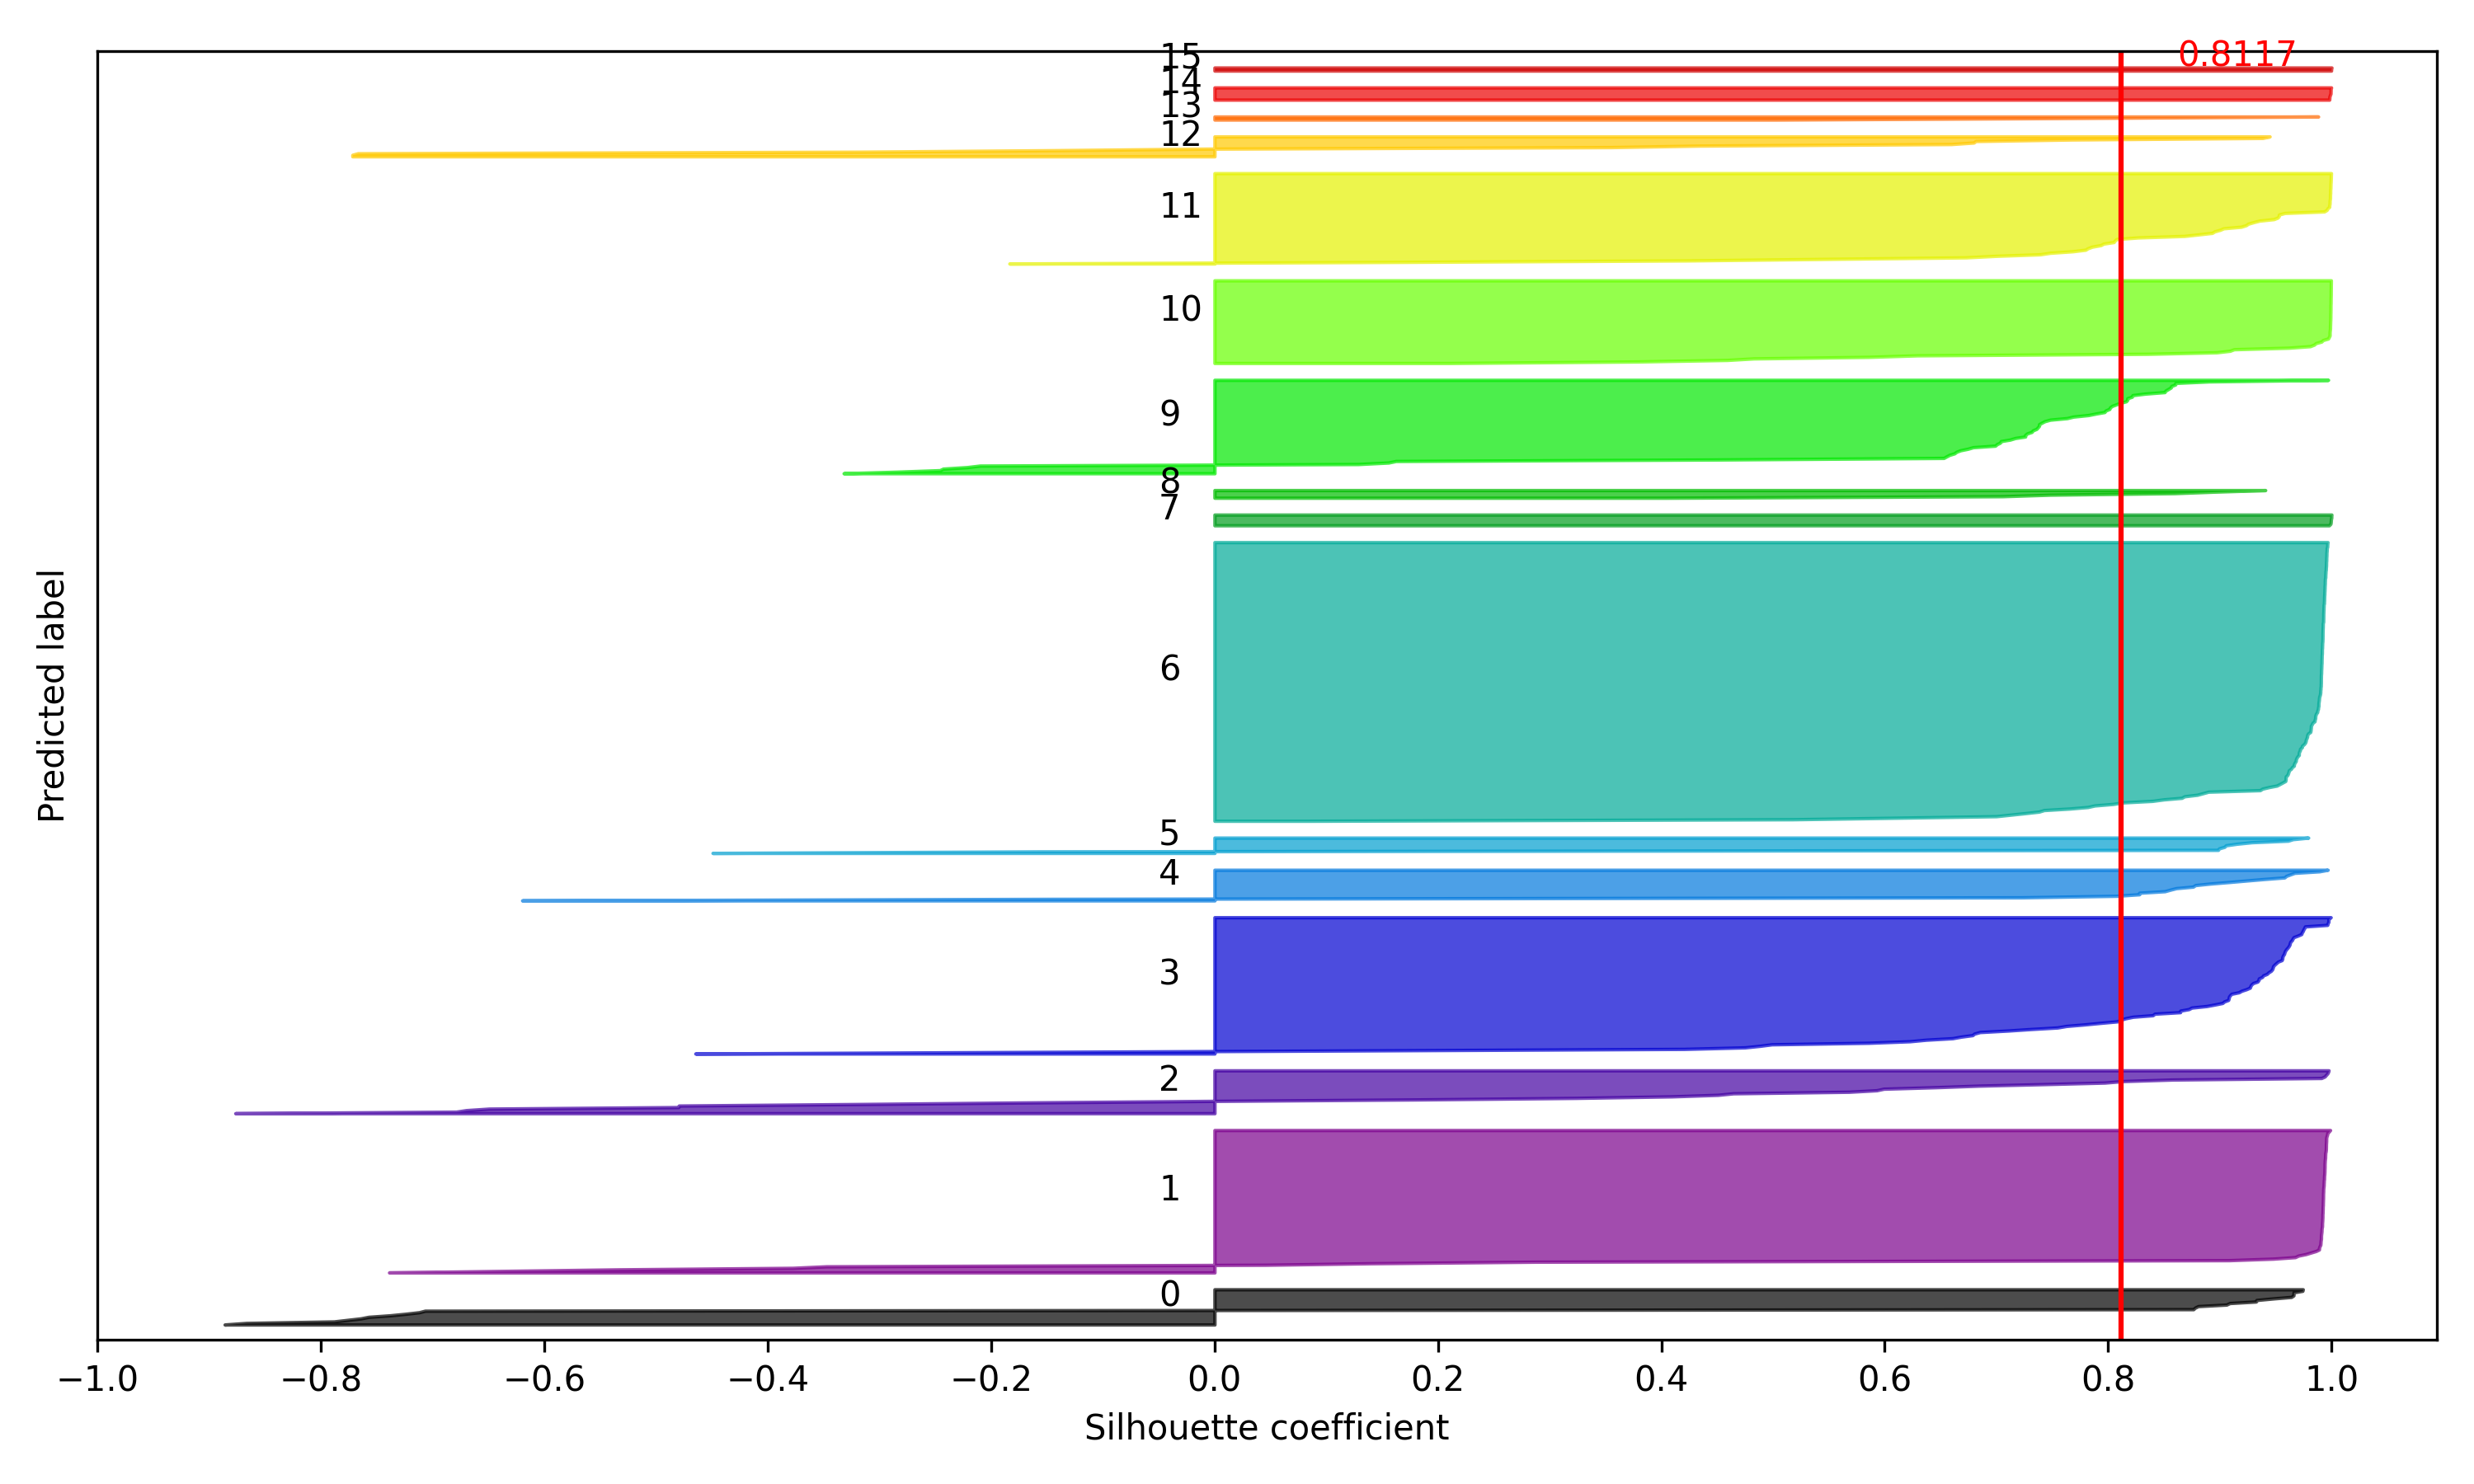

In [35]:
IPython.display.Image("results/HIV/contact/yule/silhouette.png")

In [43]:
alignment.align(method='contact', affinity='dice')

In [44]:
# Visualize cavity clusters

# Define colors
colors = [mpl.cm.nipy_spectral(float(i) / (alignment.clusters.max()+1)) for i in range(alignment.clusters.max()+1)]
print(dict(zip(range(alignment.clusters.max()+1), colors)))

# Create NGL Viewer widget
view = nglview.NGLWidget(gui=True)

# Display trajectory
pdb = view.add_component('data/HIV.pdb')
pdb.clear()
pdb.add_cartoon(color='gray')

# Display occurrence of cavity points
cavs = []

for i in range(cavities.shape[0]):
    cavs.append(view.add_component(f'results/HIV/contact/dice/cavity-{i:03d}.pdb'))
    cavs[i].clear()
#     cavs[i].add_point(color=mpl.colors.to_hex(colors[preds[i]]))
    cavs[i].add_surface(color=mpl.colors.to_hex(colors[alignment.clusters[i]]), opacity=0.5)

# Display on NGL viewer
view

{0: (0.0, 0.0, 0.0, 1.0), 1: (0.4836764705882353, 0.0, 0.5503019607843137, 1.0), 2: (0.261421568627451, 0.0, 0.6340039215686274, 1.0), 3: (0.0, 0.0, 0.8196411764705882, 1.0), 4: (0.0, 0.46931372549019607, 0.8667, 1.0), 5: (0.0, 0.6183098039215686, 0.8117980392156863, 1.0), 6: (0.0, 0.6667, 0.5960764705882353, 1.0), 7: (0.0, 0.6143862745098039, 0.11502549019607844, 1.0), 8: (0.0, 0.7385313725490196, 0.0, 1.0), 9: (0.0, 0.9059058823529412, 0.0, 1.0), 10: (0.4025960784313726, 1.0, 0.0, 1.0), 11: (0.8940843137254902, 0.9463784313725491, 0.0, 1.0), 12: (1.0, 0.7882352941176471, 0.0, 1.0), 13: (1.0, 0.4117647058823529, 0.0, 1.0), 14: (0.9242019607843137, 0.0, 0.0, 1.0), 15: (0.8117705882352941, 0.0, 0.0, 1.0)}


NGLWidget()

In [45]:
# Download image
view.download_image('HIV-contact-clustering-16.png', factor=10, trim=True, transparent=True)

### (2D) Distance matrices alignment: clustering contact matrix of each cavity detected throughout the molecular dynamics simulation

#### Explore distance metrics in 2D comparison of distance matrices

The distance metrics are used to assess the similarity of the distance matrices, ie the detected cavities.

The standard metrics
- Euclidean distance
- Correlation

Pairwise distances for numeric vectors:
- Braycurtis distance
- Canberra distance
- Chebyshev distance
- Cityblock distance
- Cosine distance
- Jensen-Shannon distance
- Mahalanobis distance
- Standardized Euclidean distance
- Squared Euclidean distance
- Weighted Minkowski distance

Reference:
https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

In [46]:
# Explore contact matrix alignment
alignment.explore(method="distance")

In [47]:
alignment.scores

,Number of Clusters,Silhouette Score
Euclidean,15.0,0.569840
Correlation,15.0,0.525135
Bray-Curtis,15.0,0.524059
Canberra,3.0,0.728975
Chebyshev,2.0,0.455468
City Block,8.0,0.714505
Cosine,15.0,0.528961
Jensen-Shannon,12.0,0.363735
Minkowski,15.0,0.569840
Squared Euclidean,15.0,0.723011


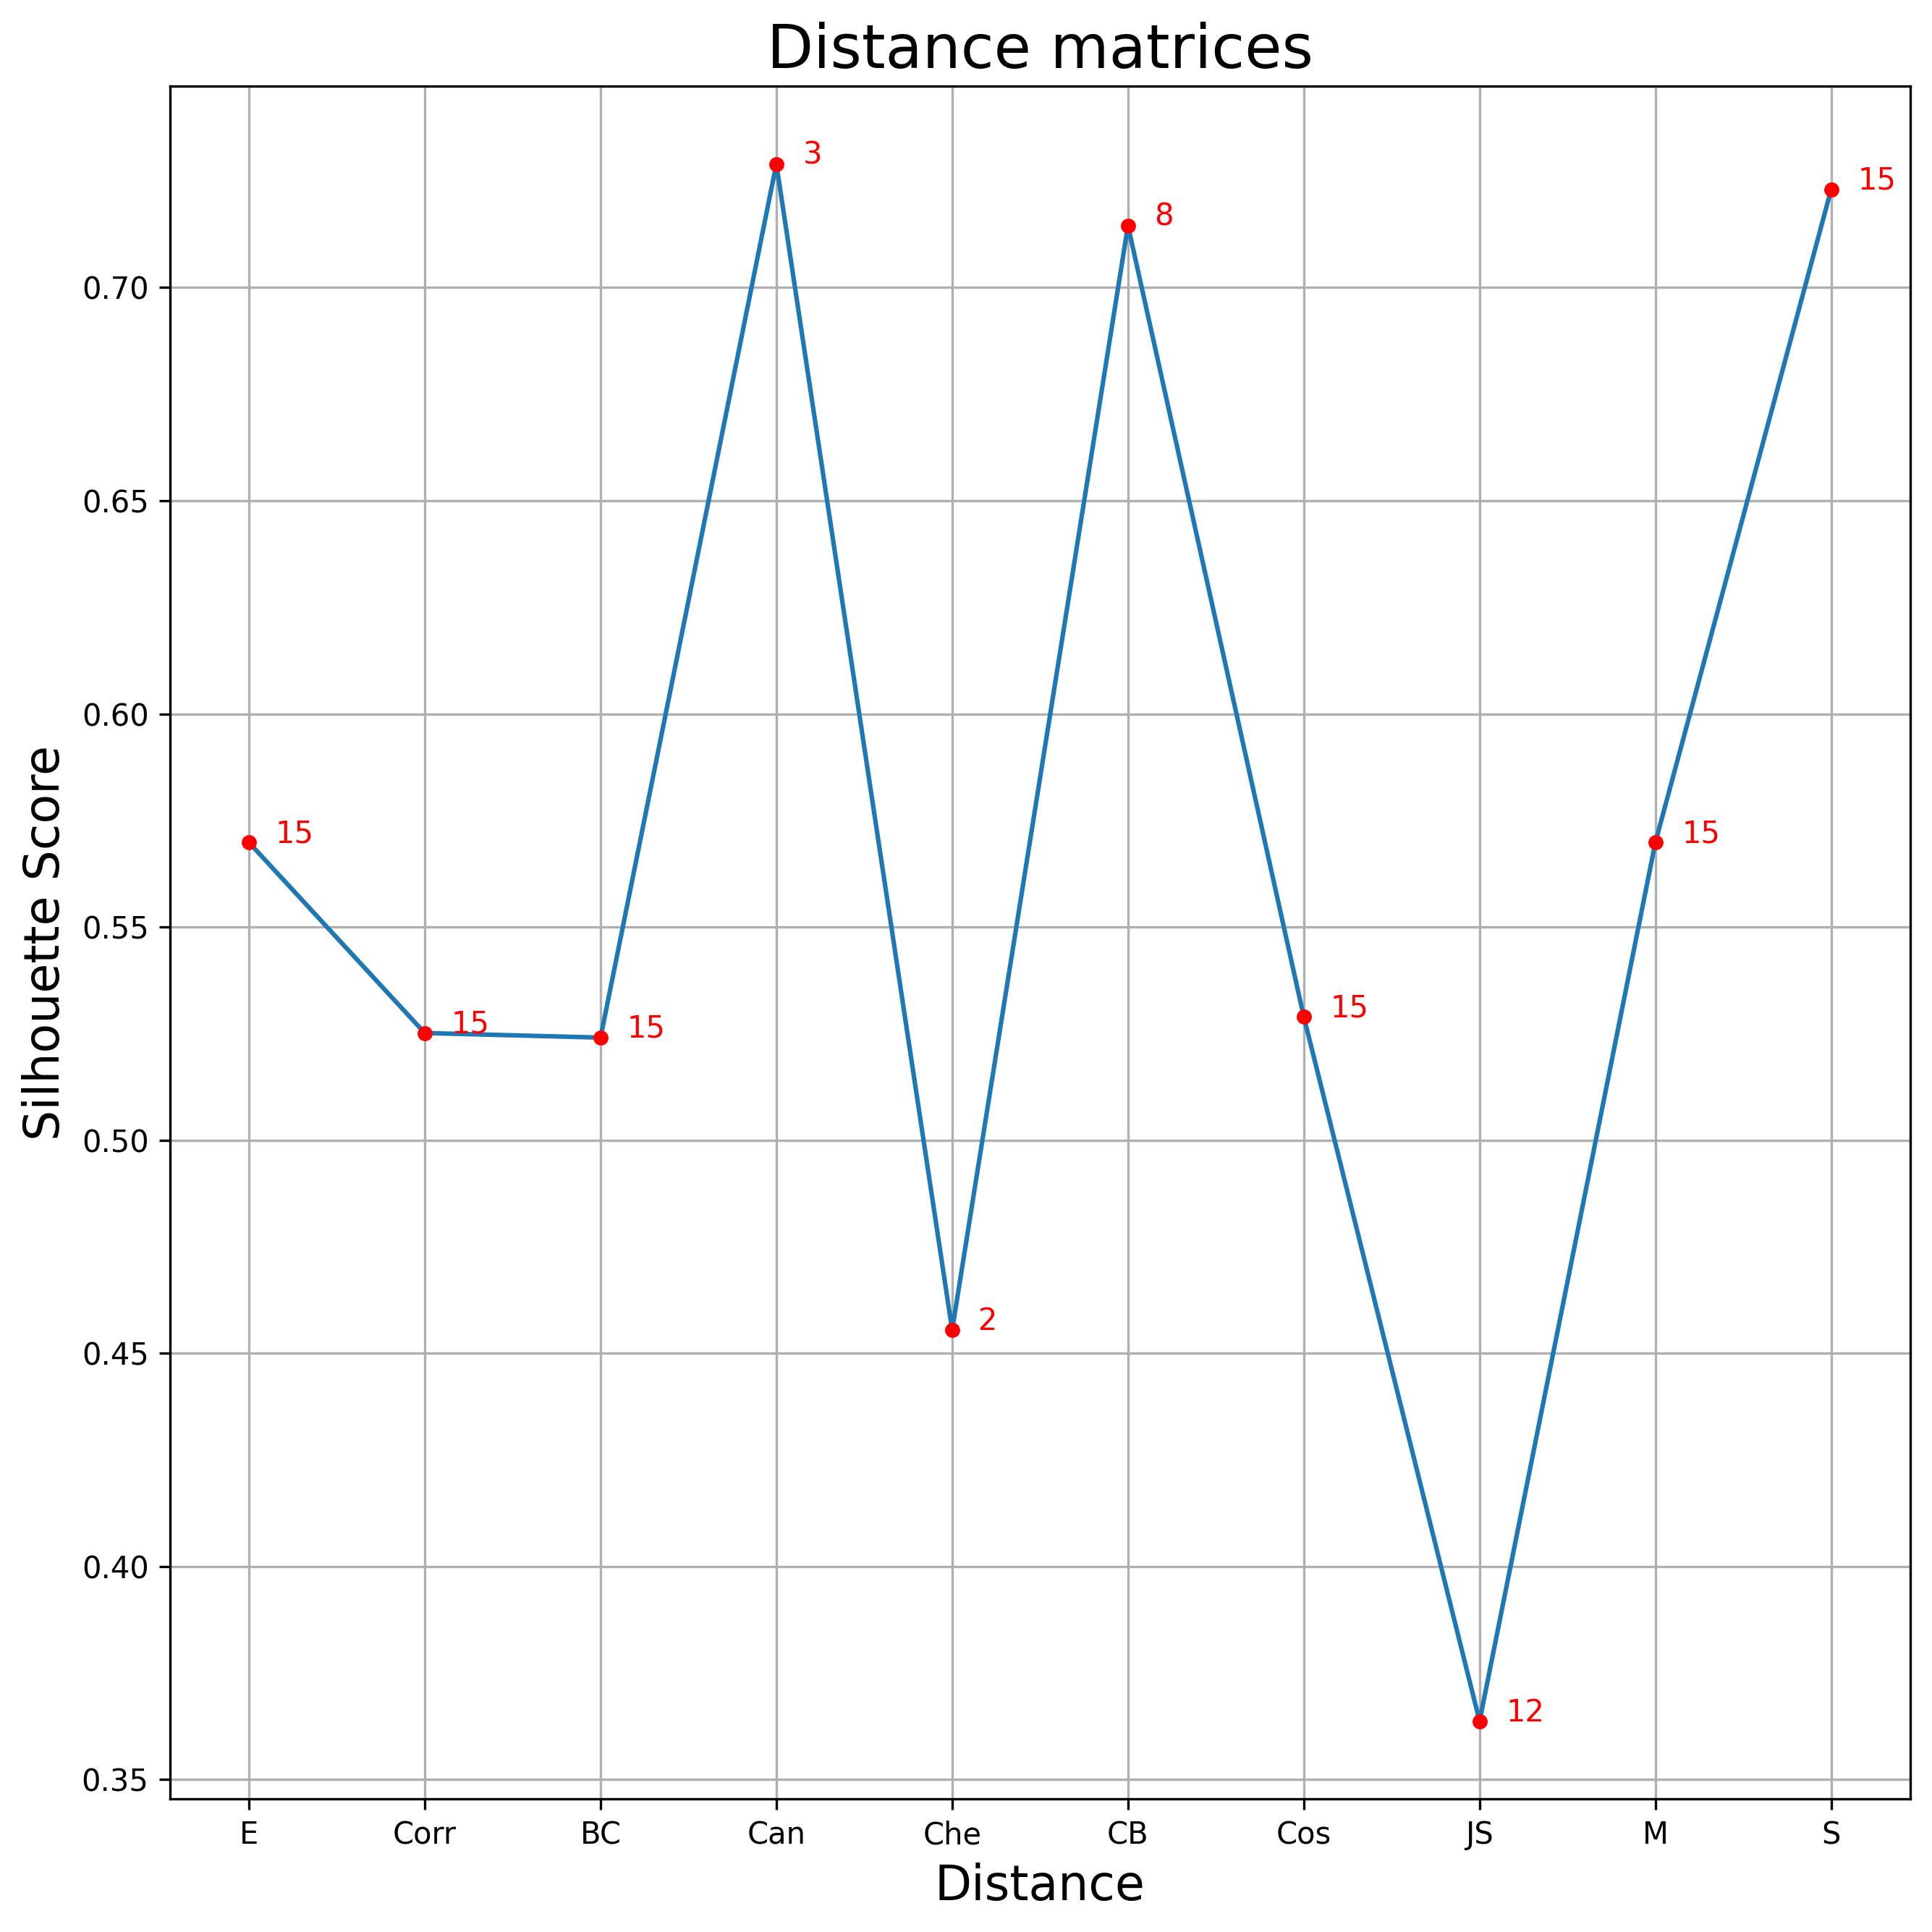

In [48]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=300, tight_layout=True, clear=True)
captions = ["E", "Corr", "BC", "Can", "Che", "CB", "Cos", "JS", "M", "S"]

# Line plot
ax.plot(captions, alignment.scores['Silhouette Score'].values)

# Plot points and text
for x, score, n_cluster in zip(
    numpy.arange(0, 10), 
    alignment.scores['Silhouette Score'].values, 
    alignment.scores['Number of Clusters'].values
):
    ax.plot(x, score, marker='o', color='red', markersize=4)
    ax.text(x + 0.15, score, int(n_cluster), color='red')

ax.grid()
ax.set_title("Distance matrices", size=20)
ax.set_ylabel("Silhouette Score", size=16)
ax.set_xlabel("Distance", size=16)

plt.savefig("results/HIV/distance/silhouette-score.png")

plt.show()

#### Agglomerative clustering based on Silhouette Score

We selected the distances that best separate the cavities, that are:
- Bray-Curtis distance
- Cosine distance
- Minkowski distance
- Squared euclidean

In [49]:
for affinity in ['braycurtis', 'cosine', 'minkowski', 'sqeuclidean']:
    
    # Alignment
    alignment.align(method='distance', affinity=affinity)
    
    # Create directory
    os.makedirs(f'results/HIV/distance/{affinity}', exist_ok=True)

    # Plot silhouette
    KVFinderMD.silhouette(
        alignment.contacts.reshape(672, -1),
        alignment.clusters,
        metric=affinity,
        filename=f'results/HIV/distance/{affinity}/silhouette.png'
    )

    # Write cavities to file
    for i, cav in enumerate(cavities):
        cav = cav.reshape(160, 126, 105)
        B = numpy.ones(cav.shape) * alignment.clusters[i]
        pyKVFinder.export(
            f'results/HIV/distance/{affinity}/cavity-{i:03d}.pdb', 
            cav.astype(int) * 2, 
            None, 
            md.kvtraj._vertices, 
            md.kvtraj._step,
            B=B
        )

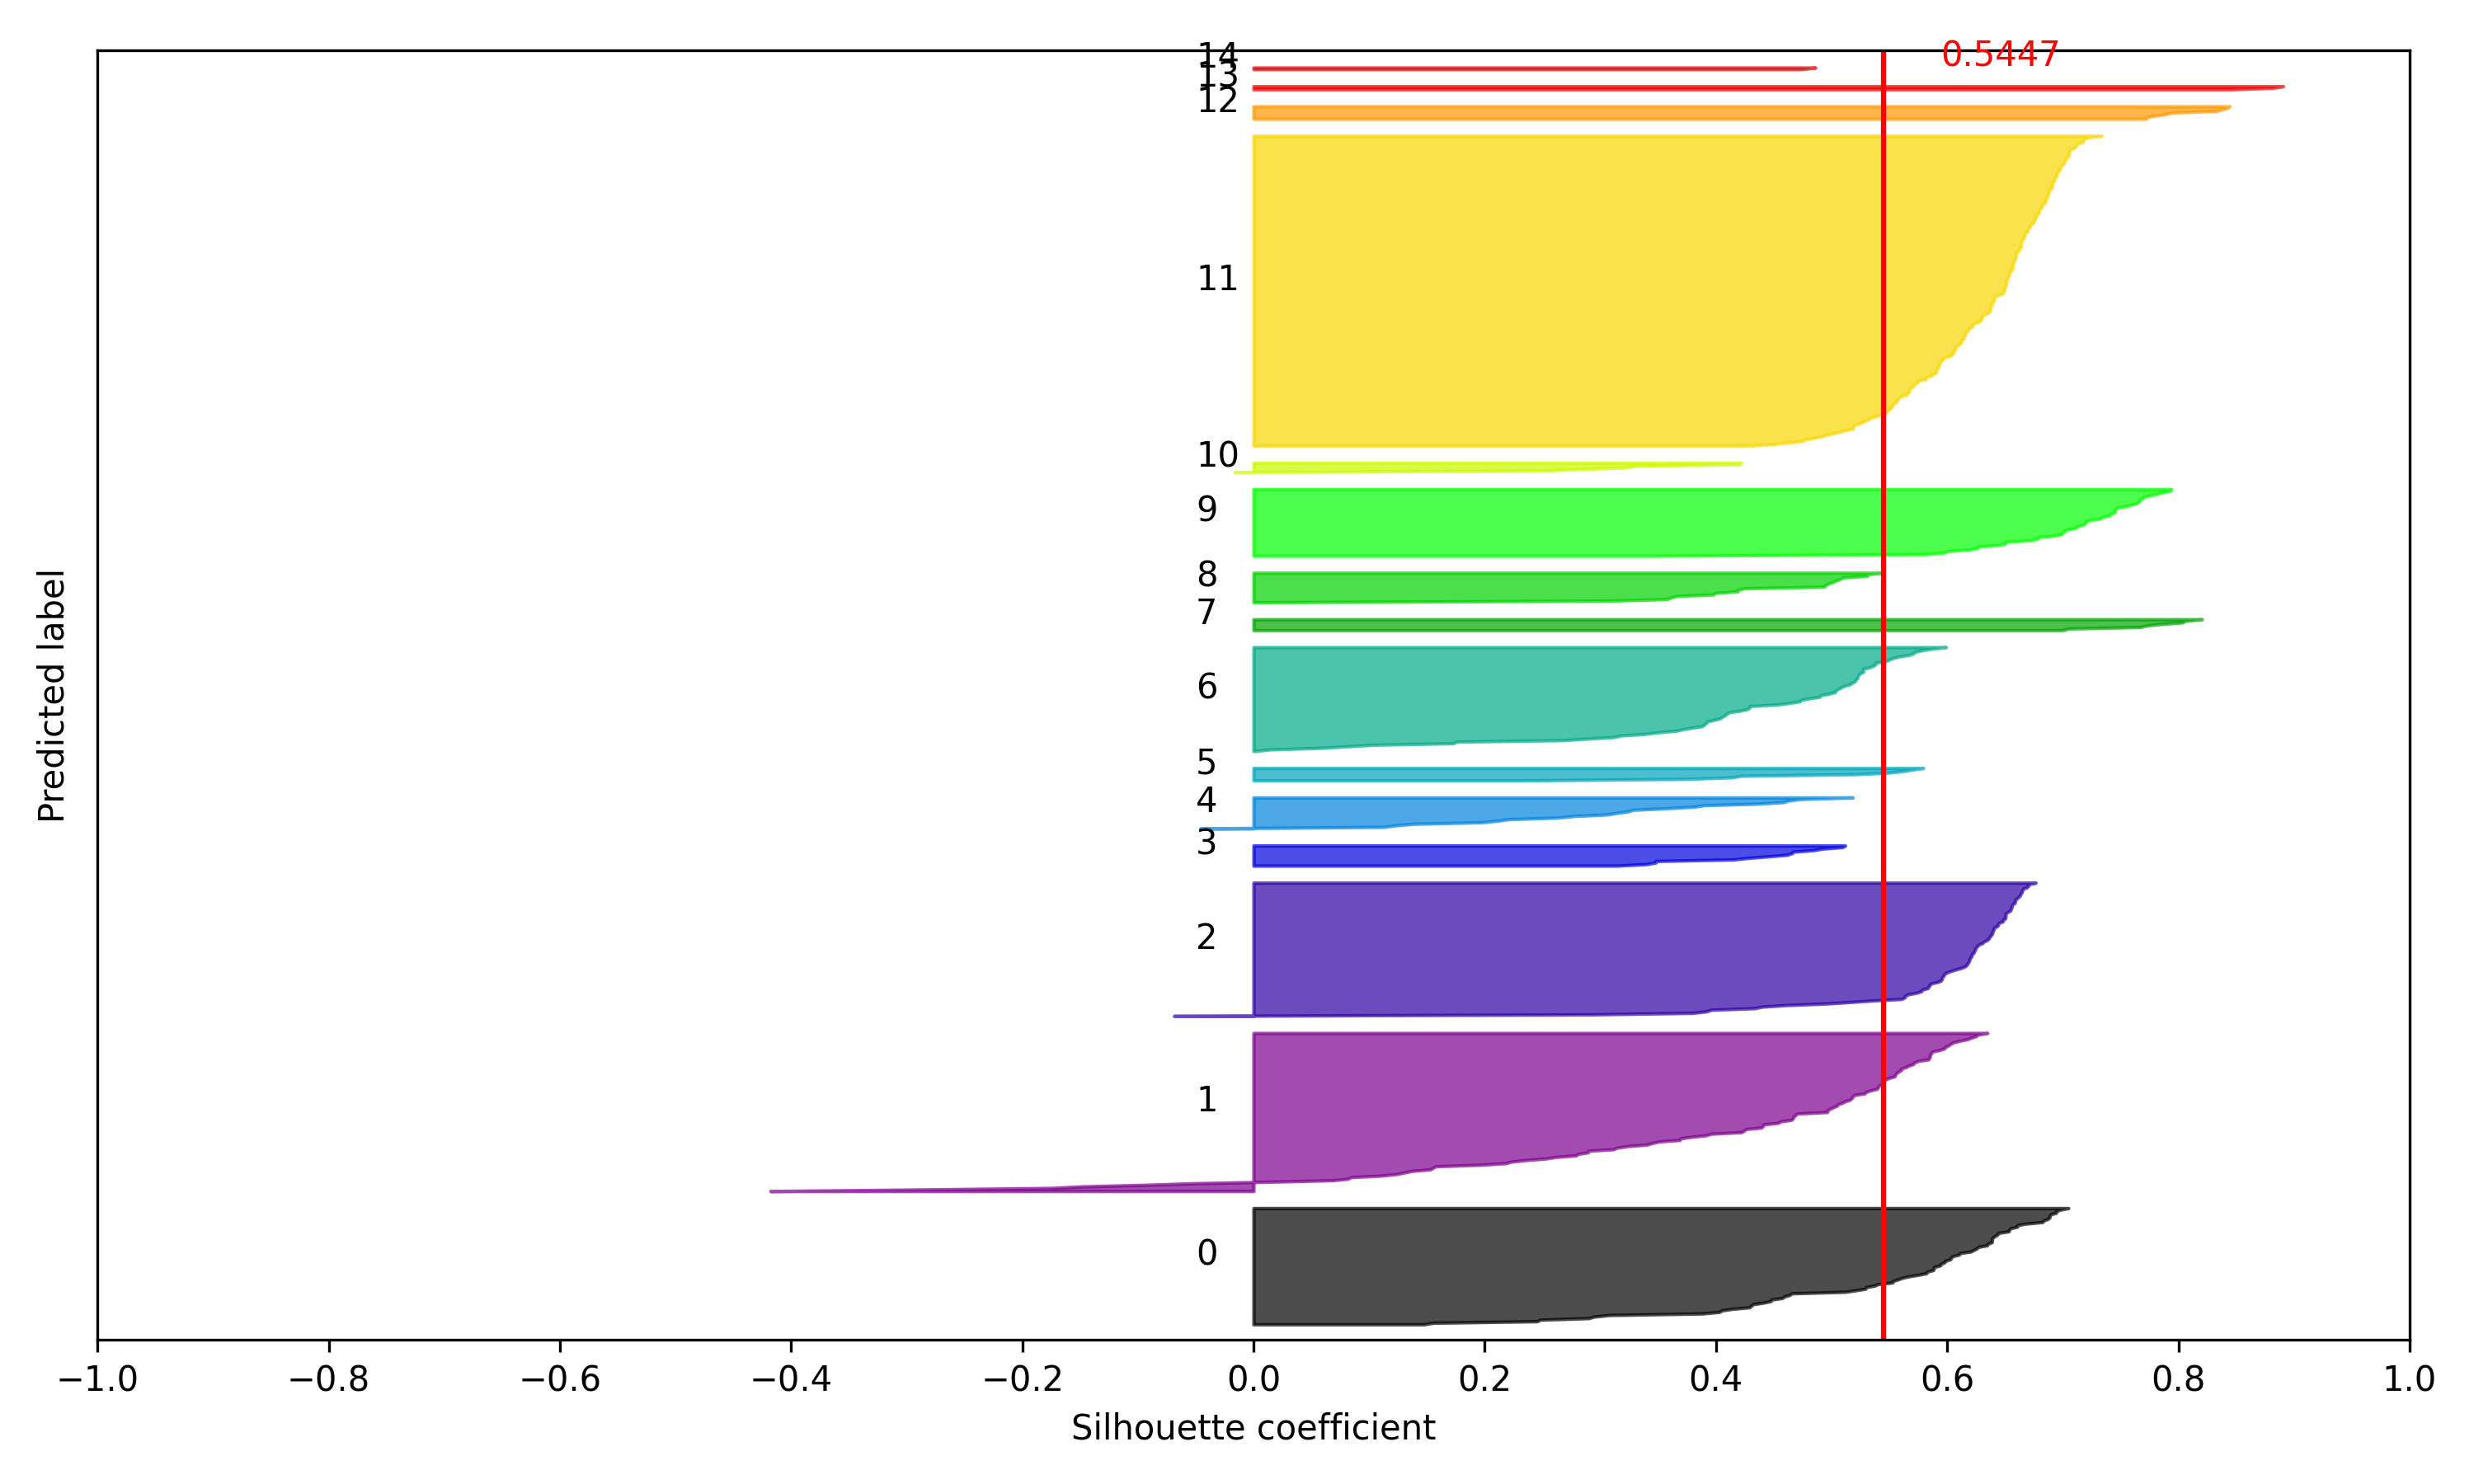

In [50]:
IPython.display.Image("results/HIV/distance/braycurtis/silhouette.png")

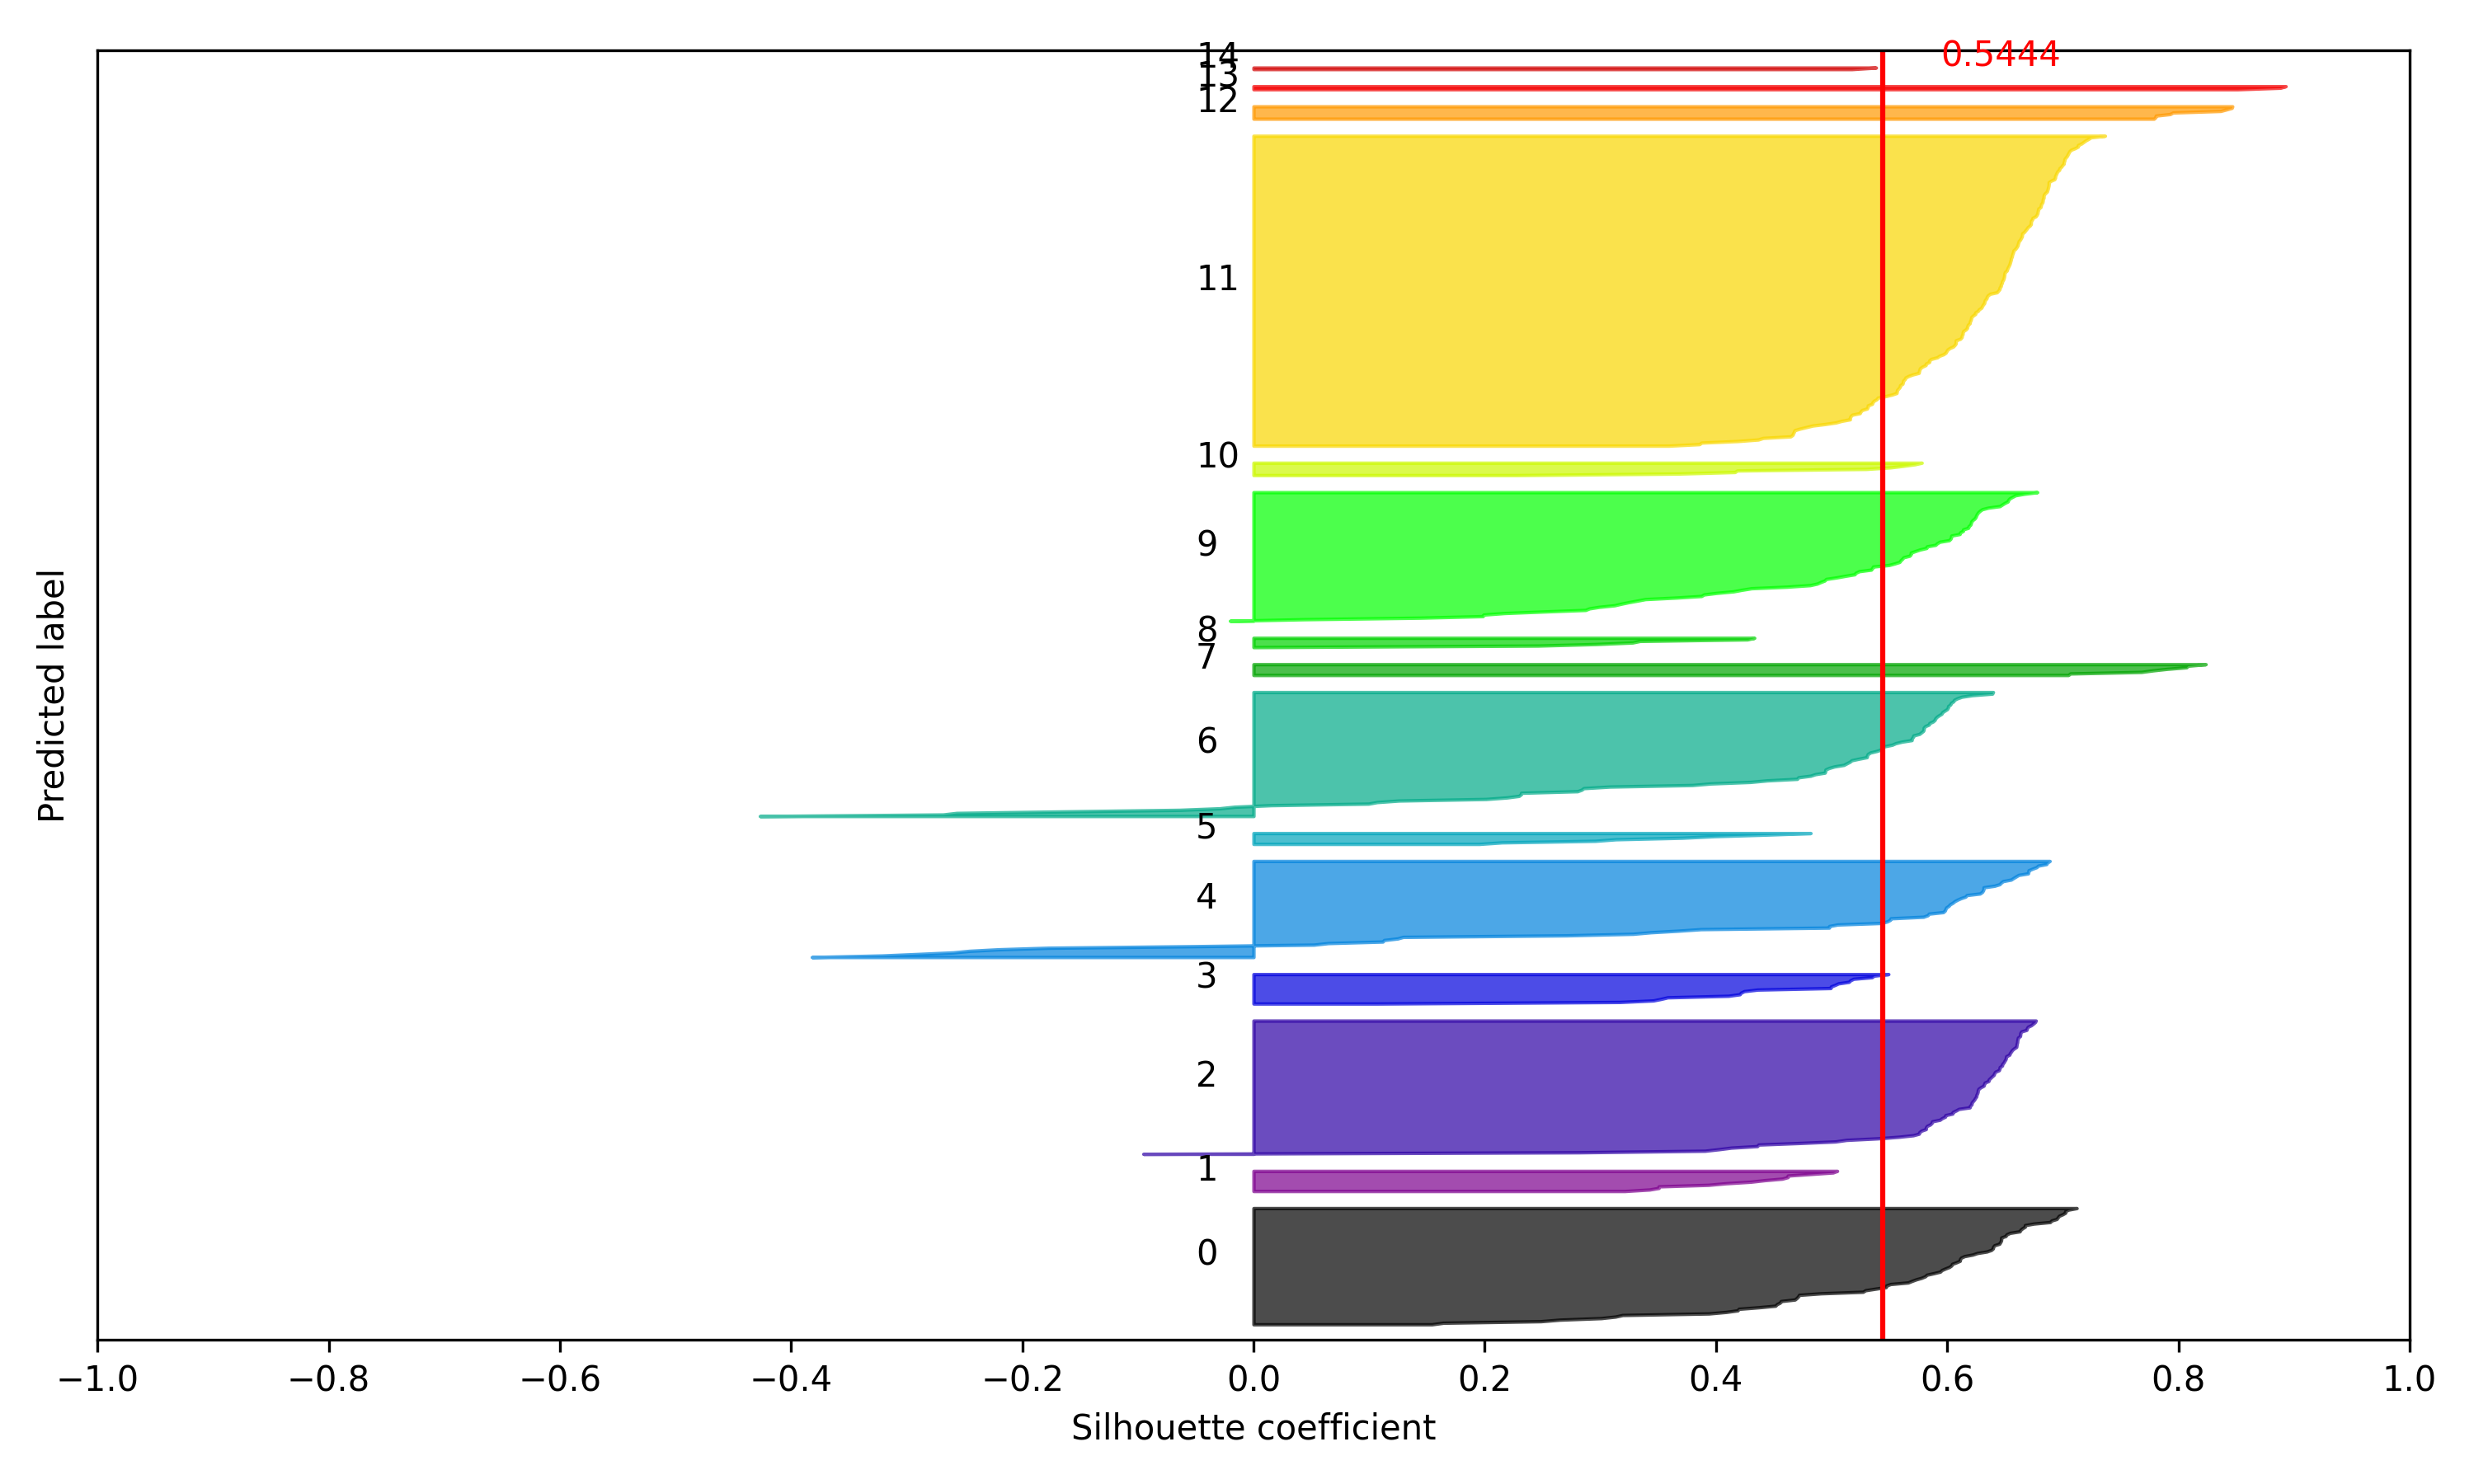

In [51]:
IPython.display.Image("results/HIV/distance/cosine/silhouette.png")

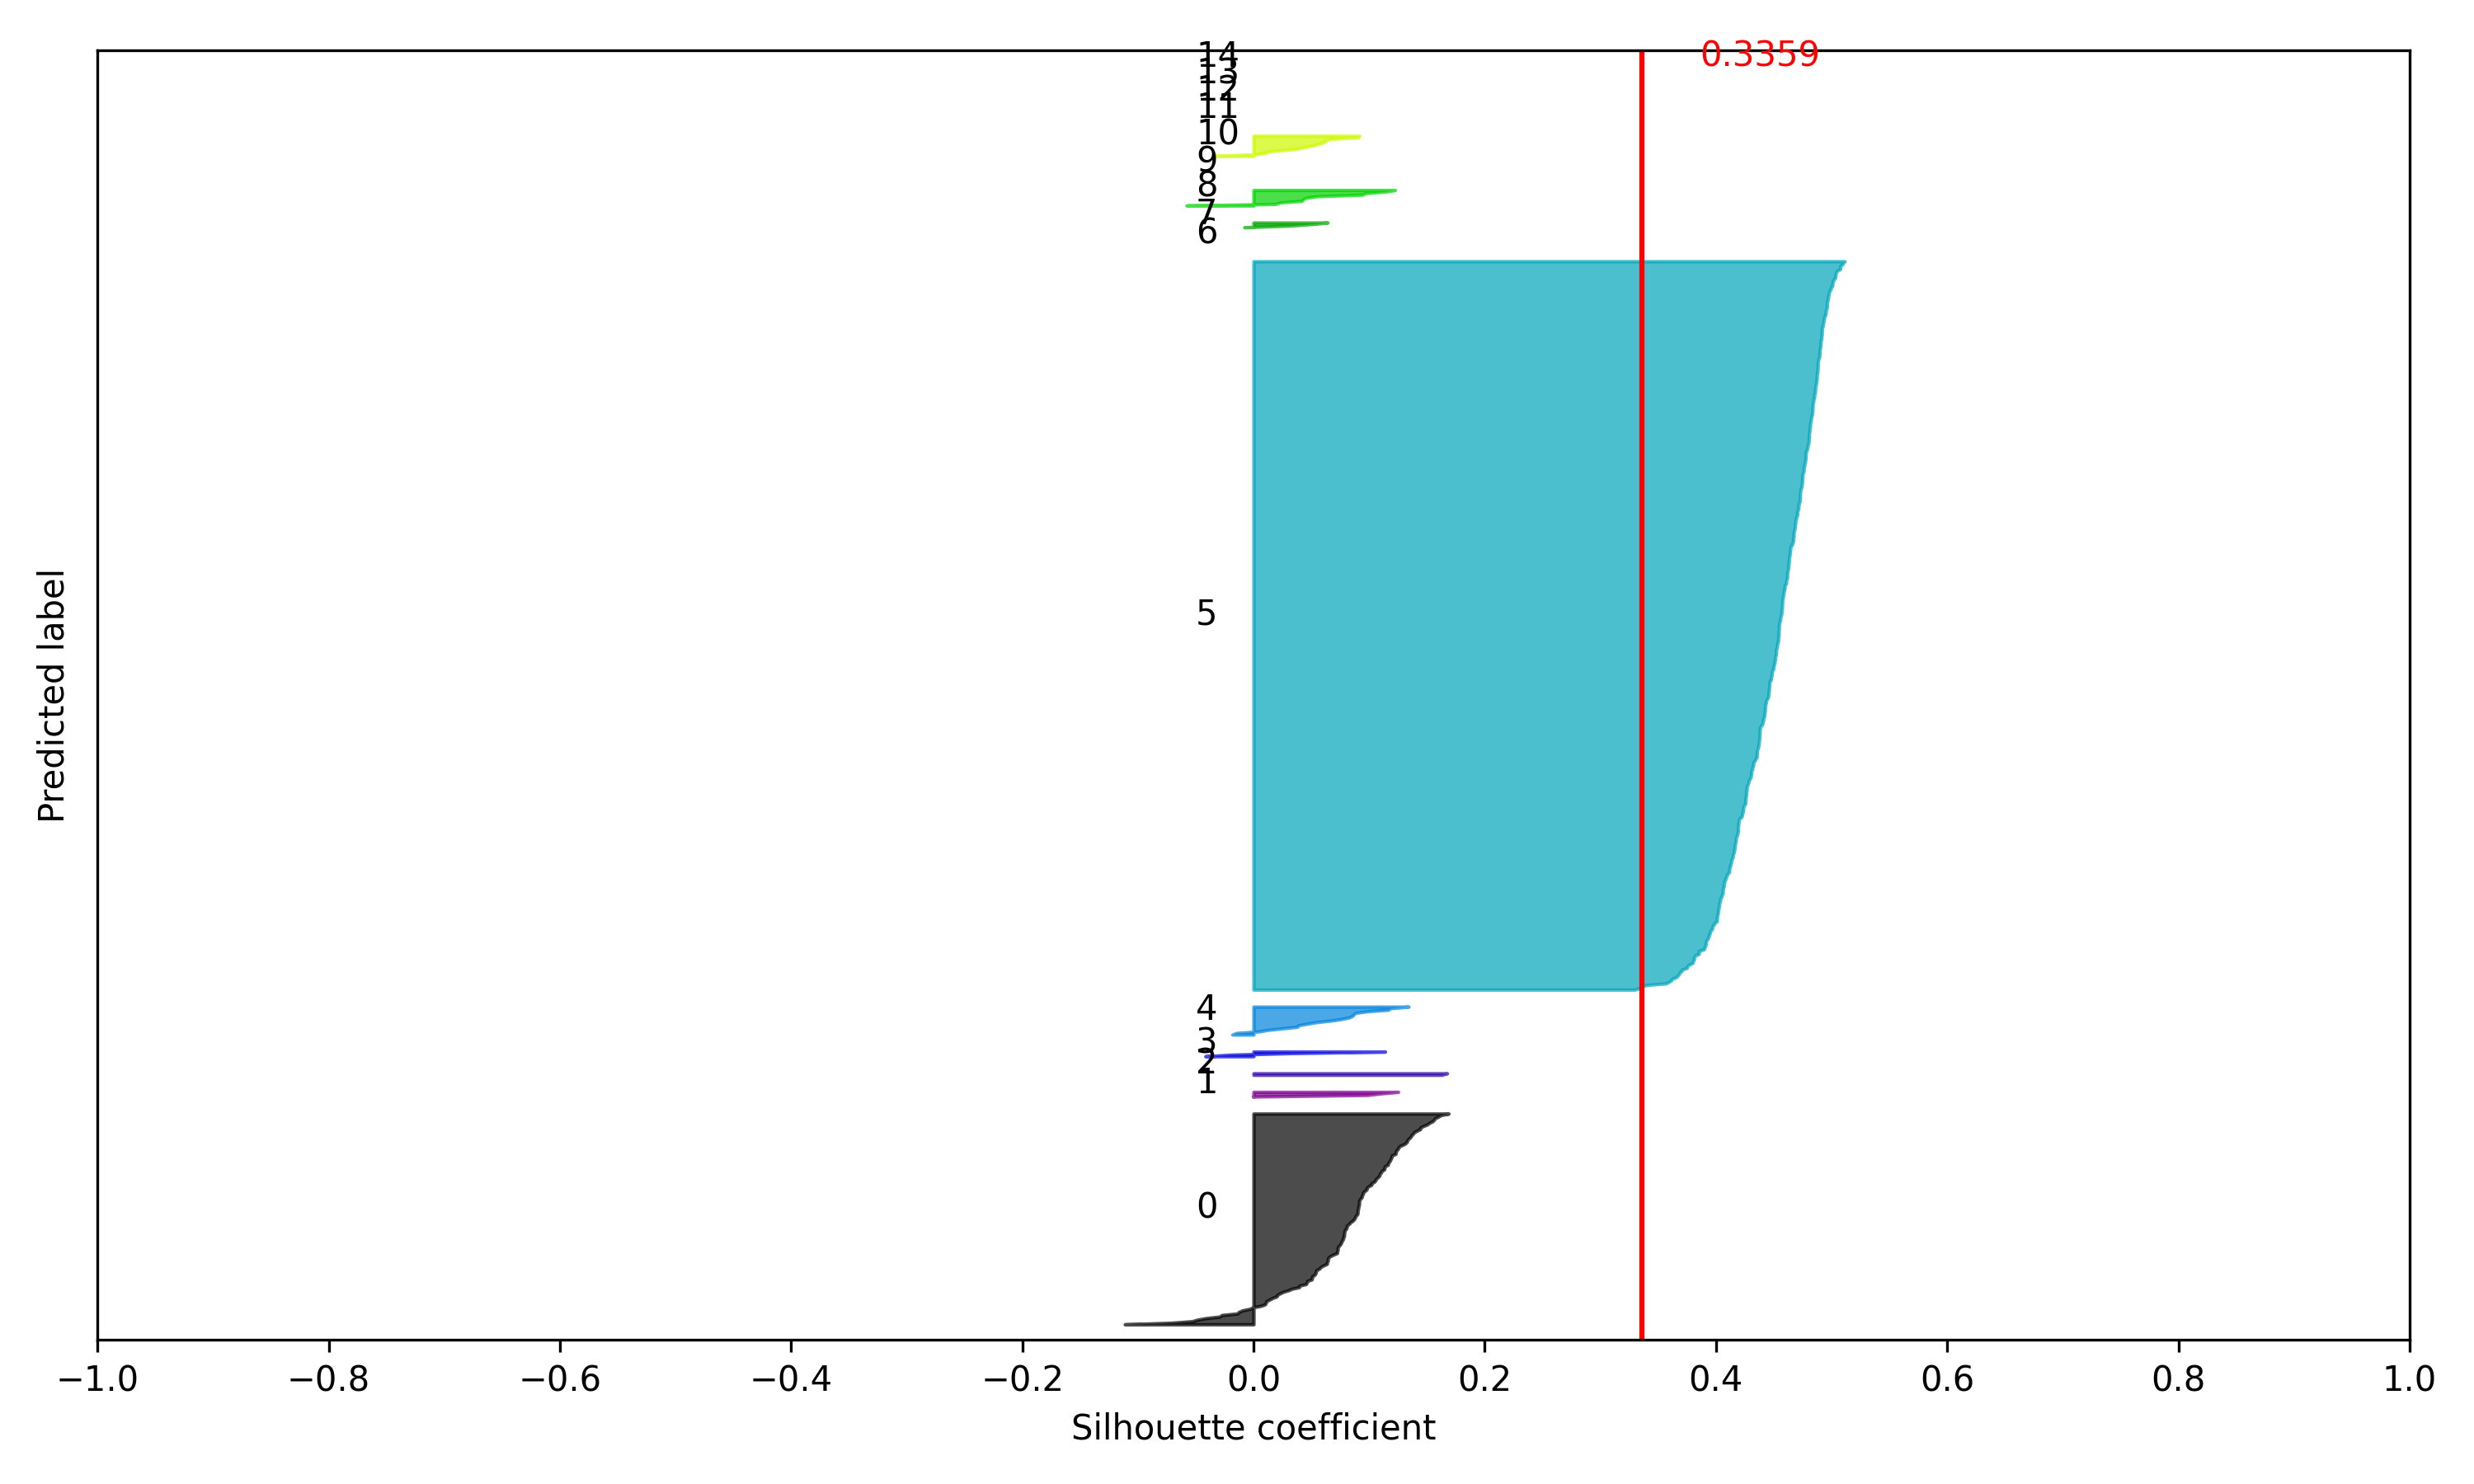

In [52]:
IPython.display.Image("results/HIV/distance/minkowski/silhouette.png")

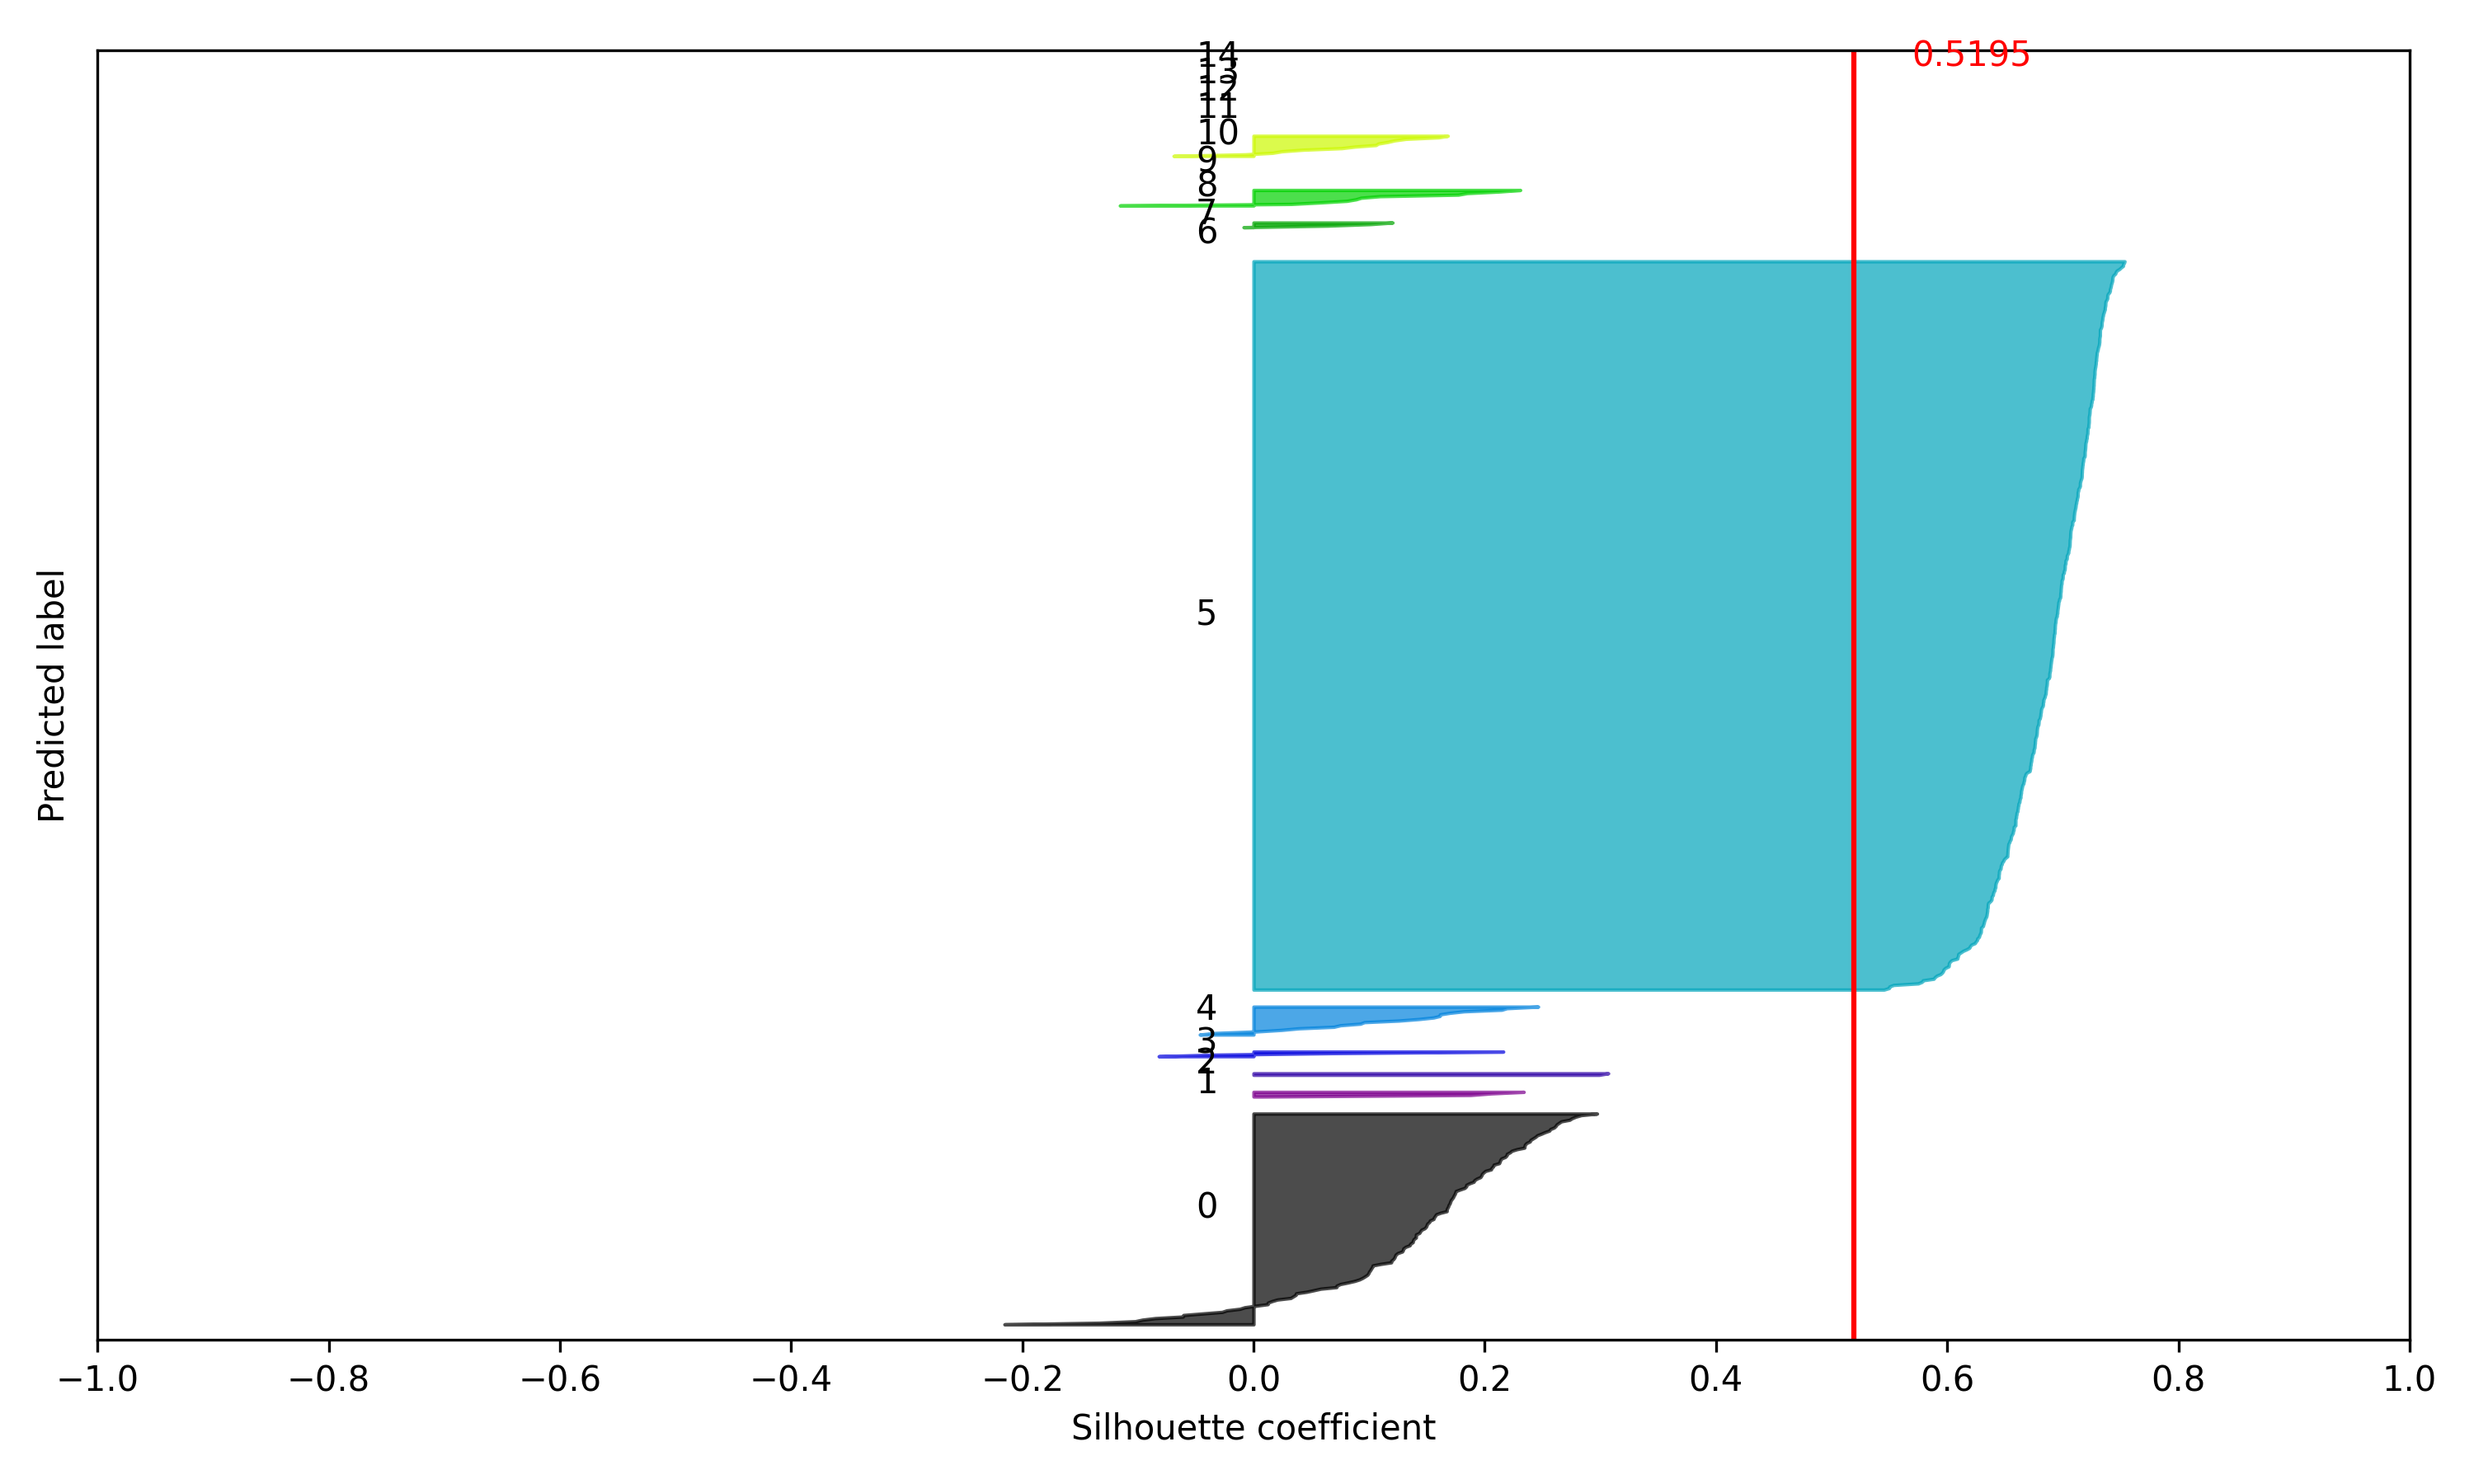

In [53]:
IPython.display.Image("results/HIV/distance/sqeuclidean/silhouette.png")

In [54]:
alignment.align(method='distance', affinity='cosine')

In [55]:
# Visualize cavity clusters

# Define colors
colors = [mpl.cm.nipy_spectral(float(i) / (alignment.clusters.max()+1)) for i in range(alignment.clusters.max()+1)]
print(dict(zip(range(alignment.clusters.max()+1), colors)))

# Create NGL Viewer widget
view = nglview.NGLWidget(gui=True)

# Display trajectory
pdb = view.add_component('data/HIV.pdb')
pdb.clear()
pdb.add_cartoon(color='gray')

# Display occurrence of cavity points
cavs = []

for i in range(cavities.shape[0]):
    cavs.append(view.add_component(f'results/HIV/distance/cosine/cavity-{i:03d}.pdb'))
    cavs[i].clear()
#     cavs[i].add_point(color=mpl.colors.to_hex(colors[preds[i]]))
    cavs[i].add_surface(color=mpl.colors.to_hex(colors[alignment.clusters[i]]), opacity=0.5)

# Display on NGL viewer
view

{0: (0.0, 0.0, 0.0, 1.0), 1: (0.4889, 0.0, 0.5555333333333333, 1.0), 2: (0.17776666666666668, 0.0, 0.6444666666666666, 1.0), 3: (0.0, 0.0, 0.8667, 1.0), 4: (0.0, 0.5111333333333333, 0.8667, 1.0), 5: (0.0, 0.6444666666666666, 0.7333666666666667, 1.0), 6: (0.0, 0.6667, 0.5333, 1.0), 7: (0.0, 0.6444333333333333, 0.0, 1.0), 8: (0.0, 0.8222333333333334, 0.0, 1.0), 9: (0.0, 1.0, 0.0, 1.0), 10: (0.7999666666666666, 0.9777666666666667, 0.0, 1.0), 11: (0.9777666666666667, 0.8444333333333334, 0.0, 1.0), 12: (1.0, 0.6, 0.0, 1.0), 13: (0.9555666666666667, 0.0, 0.0, 1.0), 14: (0.8222333333333334, 0.0, 0.0, 1.0)}


NGLWidget()

In [56]:
# Download image
view.download_image('HIV-distance-clustering-15.png', factor=10, trim=True, transparent=True)